In [85]:
import os
import json
import re
from collections import defaultdict, Counter
import functools
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator, PercentFormatter
from tqdm import tqdm
from easydict import EasyDict as edict
import ast
# from transformers import GPT2Tokenizer
import time
# from Bio import Entrez
plt.style.use('seaborn-v0_8-deep')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

### input statistics

#### initial 250

##### make the setupdf

In [ ]:
dataset_name = "manual_250"
with open(f"dset_gen/{dataset_name}-setup.json", 'r') as fh:
    dssetup = json.load(fh)

In [ ]:
rows = []
for review_pmid, qs in dssetup.items():
    for q in qs:
        q['review_pmid'] = review_pmid
        rows.append(q)
setupdf = pd.DataFrame(rows)
setupdf.loc[setupdf.evidence_quality == '', 'evidence_quality'] = 'n/a'
setupdf

In [ ]:
if not 'sla' in setupdf.columns:
    SOURCE_AGREEMENT_PCT_BINS = ['0%', '1-49%', '50%', '51-99%', '100%']
    def bin_sla_pct(x):
        if x < 0.1:
            return "0%"
        elif x < 0.5:
            return "1-49%"
        elif x == 0.5:
            return "50%"
        elif x < 1:
            return "51-99%"
        else:
            return "100%"

    ### source-level agreement calcs
    with open('run-med-evidence/___res/deepseekV3_SLA.jsonl', 'r') as fh:
        sla_data = [json.loads(l) for l in fh]

    question_source_scores = defaultdict(dict)
    for out in sla_data:
        model_ans = out.get('parsed_answer')
        ans = model_ans.get('answer', "").lower() if isinstance(model_ans, dict) else "invalid"
        score = (out['gt_answer'].lower() in ans.lower())
        question_id, source_pmid = out['question_id'].split('-')
        question_source_scores[question_id][source_pmid] = score
    sla_data = {}
    sla_data_binned = {}
    for qid, src_lbls in question_source_scores.items():
        sla_pct = sum(src_lbls.values())/len(src_lbls.values())
        sla_data[int(qid)] = sla_pct
    sla_df = pd.Series(sla_data).to_frame(name='sla').reset_index(names='question_id')
    setupdf = setupdf.merge(sla_df, on='question_id')

In [ ]:
if not 'context_tokens' in setupdf.columns:
    with open(f"run-med-evidence/datasets/manual_250-fulltext.jsonl", 'r') as fh:
        dset = [edict(json.loads(l)) for l in fh]
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    get_count = lambda s: len(tokenizer.encode(s, add_special_tokens=False, verbose=False))
    output_data = []
    for rd in tqdm(dset):
        sources = {s.article_id: s.content for s in rd.sources}
        for q in rd.question_data:
            full_text = '\n'.join(sources[pmid] for pmid in q.relevant_sources)
            output_data.append({
                'question_id': int(q.question_id),
                'context_tokens': get_count(full_text)
            })
    token_data = pd.DataFrame(output_data)
    setupdf = setupdf.merge(token_data, on='question_id')

##### meshterms

In [ ]:
outpath = "___tmp/manual_250-reviews.xml"
if not os.path.exists(outpath):
    Entrez.email = PRIVATE
    pmids = setupdf.review_pmid.unique().tolist()
    with Entrez.efetch(db="pubmed", id=pmids, retmode="xml") as handle:
        res = handle.read()
    with open(outpath, 'wb') as fh:
        fh.write(res)
review_xml = Entrez.read(outpath)
        

In [ ]:
major = 'N'
meshterms = {}
for article_elem in review_xml['PubmedArticle']:
    pmid = str(article_elem['MedlineCitation']['PMID'])
    terms = []
    for mesh in article_elem['MedlineCitation'].get('MeshHeadingList', []):
        # grab the qualifier major/minor flag, if any
        qualifiers = mesh['QualifierName']
        # if len(qualifiers) > 0:
        #     major = str(qualifiers[0].attributes.items()[0][1])
        # grab descriptor name
        descr = mesh['DescriptorName']
        terms.append(descr.title())
    meshterms[pmid] = list(set(terms))
all_meshterms = set(functools.reduce(lambda x, y: x + y, meshterms.values()))
print('\n'.join(all_meshterms))

In [ ]:
import sys
sys.path.append('run-med-evidence/src')
import queryllms
import concurrent.futures

In [ ]:
llm = queryllms.QueryLLM(provider="together", model="deepseek-ai/DeepSeek-R1-Distill-Llama-70B")

In [ ]:
base_prompt = """
Consider the following categories:
1. Internal Medicine & Subspecialties
2. Surgery
3. Pediatrics & Neonatology
4. Obstetrics & Gynecology
5. Psychiatry & Neurology
6. Oncology & Hematology
7. Emergency Medicine & Critical Care
8. Family Medicine & Preventive Care
9. Dentistry & Oral Health
10. Public Health, Epidemiology & Health Systems
11. Other

Given the following QUESTION, categorize it into the best-fitting category.
Use the following output format:
**CATEGORY**: Surgery
**REASONING**: your reasoning for your selection

Think step by step.
QUESTION: {q}
"""

In [ ]:
def parse(r):
    pattern = r"(-\s*)?\*\*(.*?)\*\*:\s*((.|\n)*?)(?=\n+(-\s*)?\*\*|\Z)"
    matches = re.findall(pattern, r , re.DOTALL) # Extract matches
    if matches:
        # Convert to a dictionary
        parsed_data = {}
        for (_,key,value,_,_) in matches:
            formatted_key = key.strip().lower().replace(" ","_")
            parsed_data[formatted_key] = value.strip()
        return parsed_data
    else:
        return {'unknown': r}

def ask(question_id, question):
    prompt = base_prompt.format(q=question)
    response = llm.simple_query('follow instruction', prompt)
    parsed = parse(response)
    return (question_id, parsed)

responses = []
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    futures = [executor.submit(ask, q.question_id, q.question) for _,q in setupdf.iterrows()]
    with tqdm(total=len(setupdf), desc="answering questions") as pbar:
        for future in concurrent.futures.as_completed(futures):
            responses.append(future.result())
            pbar.update()
print(responses[12])

In [ ]:
categorydata = []
for (qid, r) in responses:
    categorydata.append({
        'question_id': qid,
        'med_specialty': r['category']
    })
categorydf = pd.DataFrame(categorydata)
setupdf = setupdf.merge(categorydf, on='question_id')

In [ ]:
Counter(setupdf.med_specialty.values)

##### add dates

In [469]:
# import download_pubmed_data as dpd
# data = dpd.get_review_pmid_data()
import pickle
with open('review_known_pmid_data.pkl', 'rb') as fh:
    data = pickle.load(fh)

In [470]:
year_map = {}
for review_pmid in setupdf.review_pmid.unique():
    year = int(data[review_pmid]['date'][:4])
    year_map[review_pmid] = year
setupdf['review_year'] = setupdf.review_pmid.map(year_map)
setupdf.to_csv('run-med-evidence/___res/dataset_stats.csv', index=False)

#### additional data

In [ ]:
import ast
setupdf_250 = pd.read_csv('run-med-evidence/___res/dataset_stats_250.csv')
setupdf_250.loc[:,'relevant_sources'] = setupdf_250['relevant_sources'].apply(ast.literal_eval)
setupdf_250['review_pmid'] = setupdf_250['review_pmid'].astype(str)
setupdf_250.loc[:, 'evidence_quality'] = setupdf_250['evidence_quality'].fillna('N/A')

In [ ]:
dataset_name = "manual_284"
with open(f"dset_gen/{dataset_name}-setup.json", 'r') as fh:
    dssetup = json.load(fh)
rows = []
for review_pmid, qs in dssetup.items():
    for q in qs:
        q['review_pmid'] = review_pmid
        rows.append(q)
setupdf = pd.DataFrame(rows)
setupdf.loc[setupdf.evidence_quality == '', 'evidence_quality'] = 'n/a'
new_df = setupdf[setupdf.question_id > 249]

In [ ]:
SOURCE_AGREEMENT_PCT_BINS = ['0%', '1-49%', '50%', '51-99%', '100%']
def bin_sla_pct(x):
    if x < 0.1:
        return "0%"
    elif x < 0.5:
        return "1-49%"
    elif x == 0.5:
        return "50%"
    elif x < 1:
        return "51-99%"
    else:
        return "100%"

### source-level agreement calcs
with open('run-med-evidence/___res/deepseekV3_SLA.jsonl', 'r') as fh:
    sla_data = [json.loads(l) for l in fh]

question_source_scores = defaultdict(dict)
for out in sla_data:
    model_ans = out.get('parsed_answer')
    ans = model_ans.get('answer', "").lower() if isinstance(model_ans, dict) else "invalid"
    score = (out['gt_answer'].lower() in ans.lower())
    question_id, source_pmid = out['question_id'].split('-')
    question_source_scores[question_id][source_pmid] = score
sla_data = {}
sla_data_binned = {}
for qid, src_lbls in question_source_scores.items():
    sla_pct = sum(src_lbls.values())/len(src_lbls.values())
    sla_data[int(qid)] = sla_pct
sla_df = pd.Series(sla_data).to_frame(name='sla').reset_index(names='question_id')
new_df = new_df.merge(sla_df, on='question_id', how='left')

In [ ]:
import sys
sys.path.append('run-med-evidence/src')
import queryllms
import concurrent.futures

base_prompt = """
Consider the following categories:
1. Internal Medicine & Subspecialties
2. Surgery
3. Pediatrics & Neonatology
4. Obstetrics & Gynecology
5. Psychiatry & Neurology
6. Oncology & Hematology
7. Emergency Medicine & Critical Care
8. Family Medicine & Preventive Care
9. Dentistry & Oral Health
10. Public Health, Epidemiology & Health Systems
11. Other

Given the following QUESTION, categorize it into the best-fitting category.
Use the following output format:
**CATEGORY**: Surgery
**REASONING**: your reasoning for your selection

Think step by step.
QUESTION: {q}
"""
llm = queryllms.QueryLLM(provider="together", model="deepseek-ai/DeepSeek-R1-Distill-Llama-70B")

In [ ]:
def parse(r):
    pattern = r"(-\s*)?\*\*(.*?)\*\*:\s*((.|\n)*?)(?=\n+(-\s*)?\*\*|\Z)"
    matches = re.findall(pattern, r , re.DOTALL) # Extract matches
    if matches:
        # Convert to a dictionary
        parsed_data = {}
        for (_,key,value,_,_) in matches:
            formatted_key = key.strip().lower().replace(" ","_")
            parsed_data[formatted_key] = value.strip()
        return parsed_data
    else:
        return {'unknown': r}

def ask(question_id, question):
    prompt = base_prompt.format(q=question)
    response = llm.simple_query('follow instruction', prompt)
    parsed = parse(response)
    return (question_id, parsed)

responses = []
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    futures = [executor.submit(ask, q.question_id, q.question) for _,q in new_df.iterrows()]
    with tqdm(total=len(new_df), desc="answering questions") as pbar:
        for future in concurrent.futures.as_completed(futures):
            responses.append(future.result())
            pbar.update()
print(responses[12])

In [ ]:
categorydata = []
for (qid, r) in responses:
    categorydata.append({
        'question_id': qid,
        'med_specialty': r['category']
    })
categorydf = pd.DataFrame(categorydata)
new_df = new_df.merge(categorydf, on='question_id')

In [ ]:
full_df = pd.concat([setupdf_250, new_df])
full_df.to_csv('run-med-evidence/___res/dataset_stats.csv', index=False)

#### plot stats

In [471]:
import ast
setupdf = pd.read_csv('run-med-evidence/___res/dataset_stats.csv')
setupdf.loc[:,'relevant_sources'] = setupdf['relevant_sources'].apply(ast.literal_eval)
setupdf['review_pmid'] = setupdf['review_pmid'].astype(str)
setupdf.loc[:, 'evidence_quality'] = setupdf['evidence_quality'].fillna('N/A')
setupdf['review_year'] = setupdf['review_year'].apply(lambda x: str(int(x)))

In [ ]:
setupdf['nsrc'] = [len(x) if len(x) < 4 else 4 for x in setupdf.relevant_sources]

In [ ]:
setupdf.groupby(['nsrc', 'answer']).agg({'question_id':'count'})

In [ ]:
srcs = []
for r in setup_data:
    for q in setup_data[r]:
        srcs += q['relevant_sources']
print(len(set(srcs)))
        

In [ ]:
a = []
for x in setupdf.relevant_sources.values:
    a += x
print(len(a))
print(len(set(a)))

In [204]:
def donut_plot(ax, data, labels, pal, **kwargs):
    wedges, texts, autotexts = ax.pie(data, wedgeprops=dict(width=0.6), colors=pal, autopct="%1.1f%%",
        labels=labels, #textprops={'bbox': dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)},
        pctdistance=0.7, explode=[0.03]*len(data), **kwargs)
    for i, a in enumerate(autotexts):
        a.set_bbox(None)
    return ax

/var/folders/cp/ps4v9yh52dj0wy2dnwf912cr0000gn/T/ipykernel_26198/3162457959.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eqdf = setupdf.groupby('evidence_quality').apply(lambda x: x.sort_values('answer')).loc[qual_order]
/var/folders/cp/ps4v9yh52dj0wy2dnwf912cr0000gn/T/ipykernel_26198/3162457959.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=30)
/var/folders/cp/ps4v9yh52dj0wy2dnwf912cr0000gn/T/ipykernel_26198/3162457959.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a f

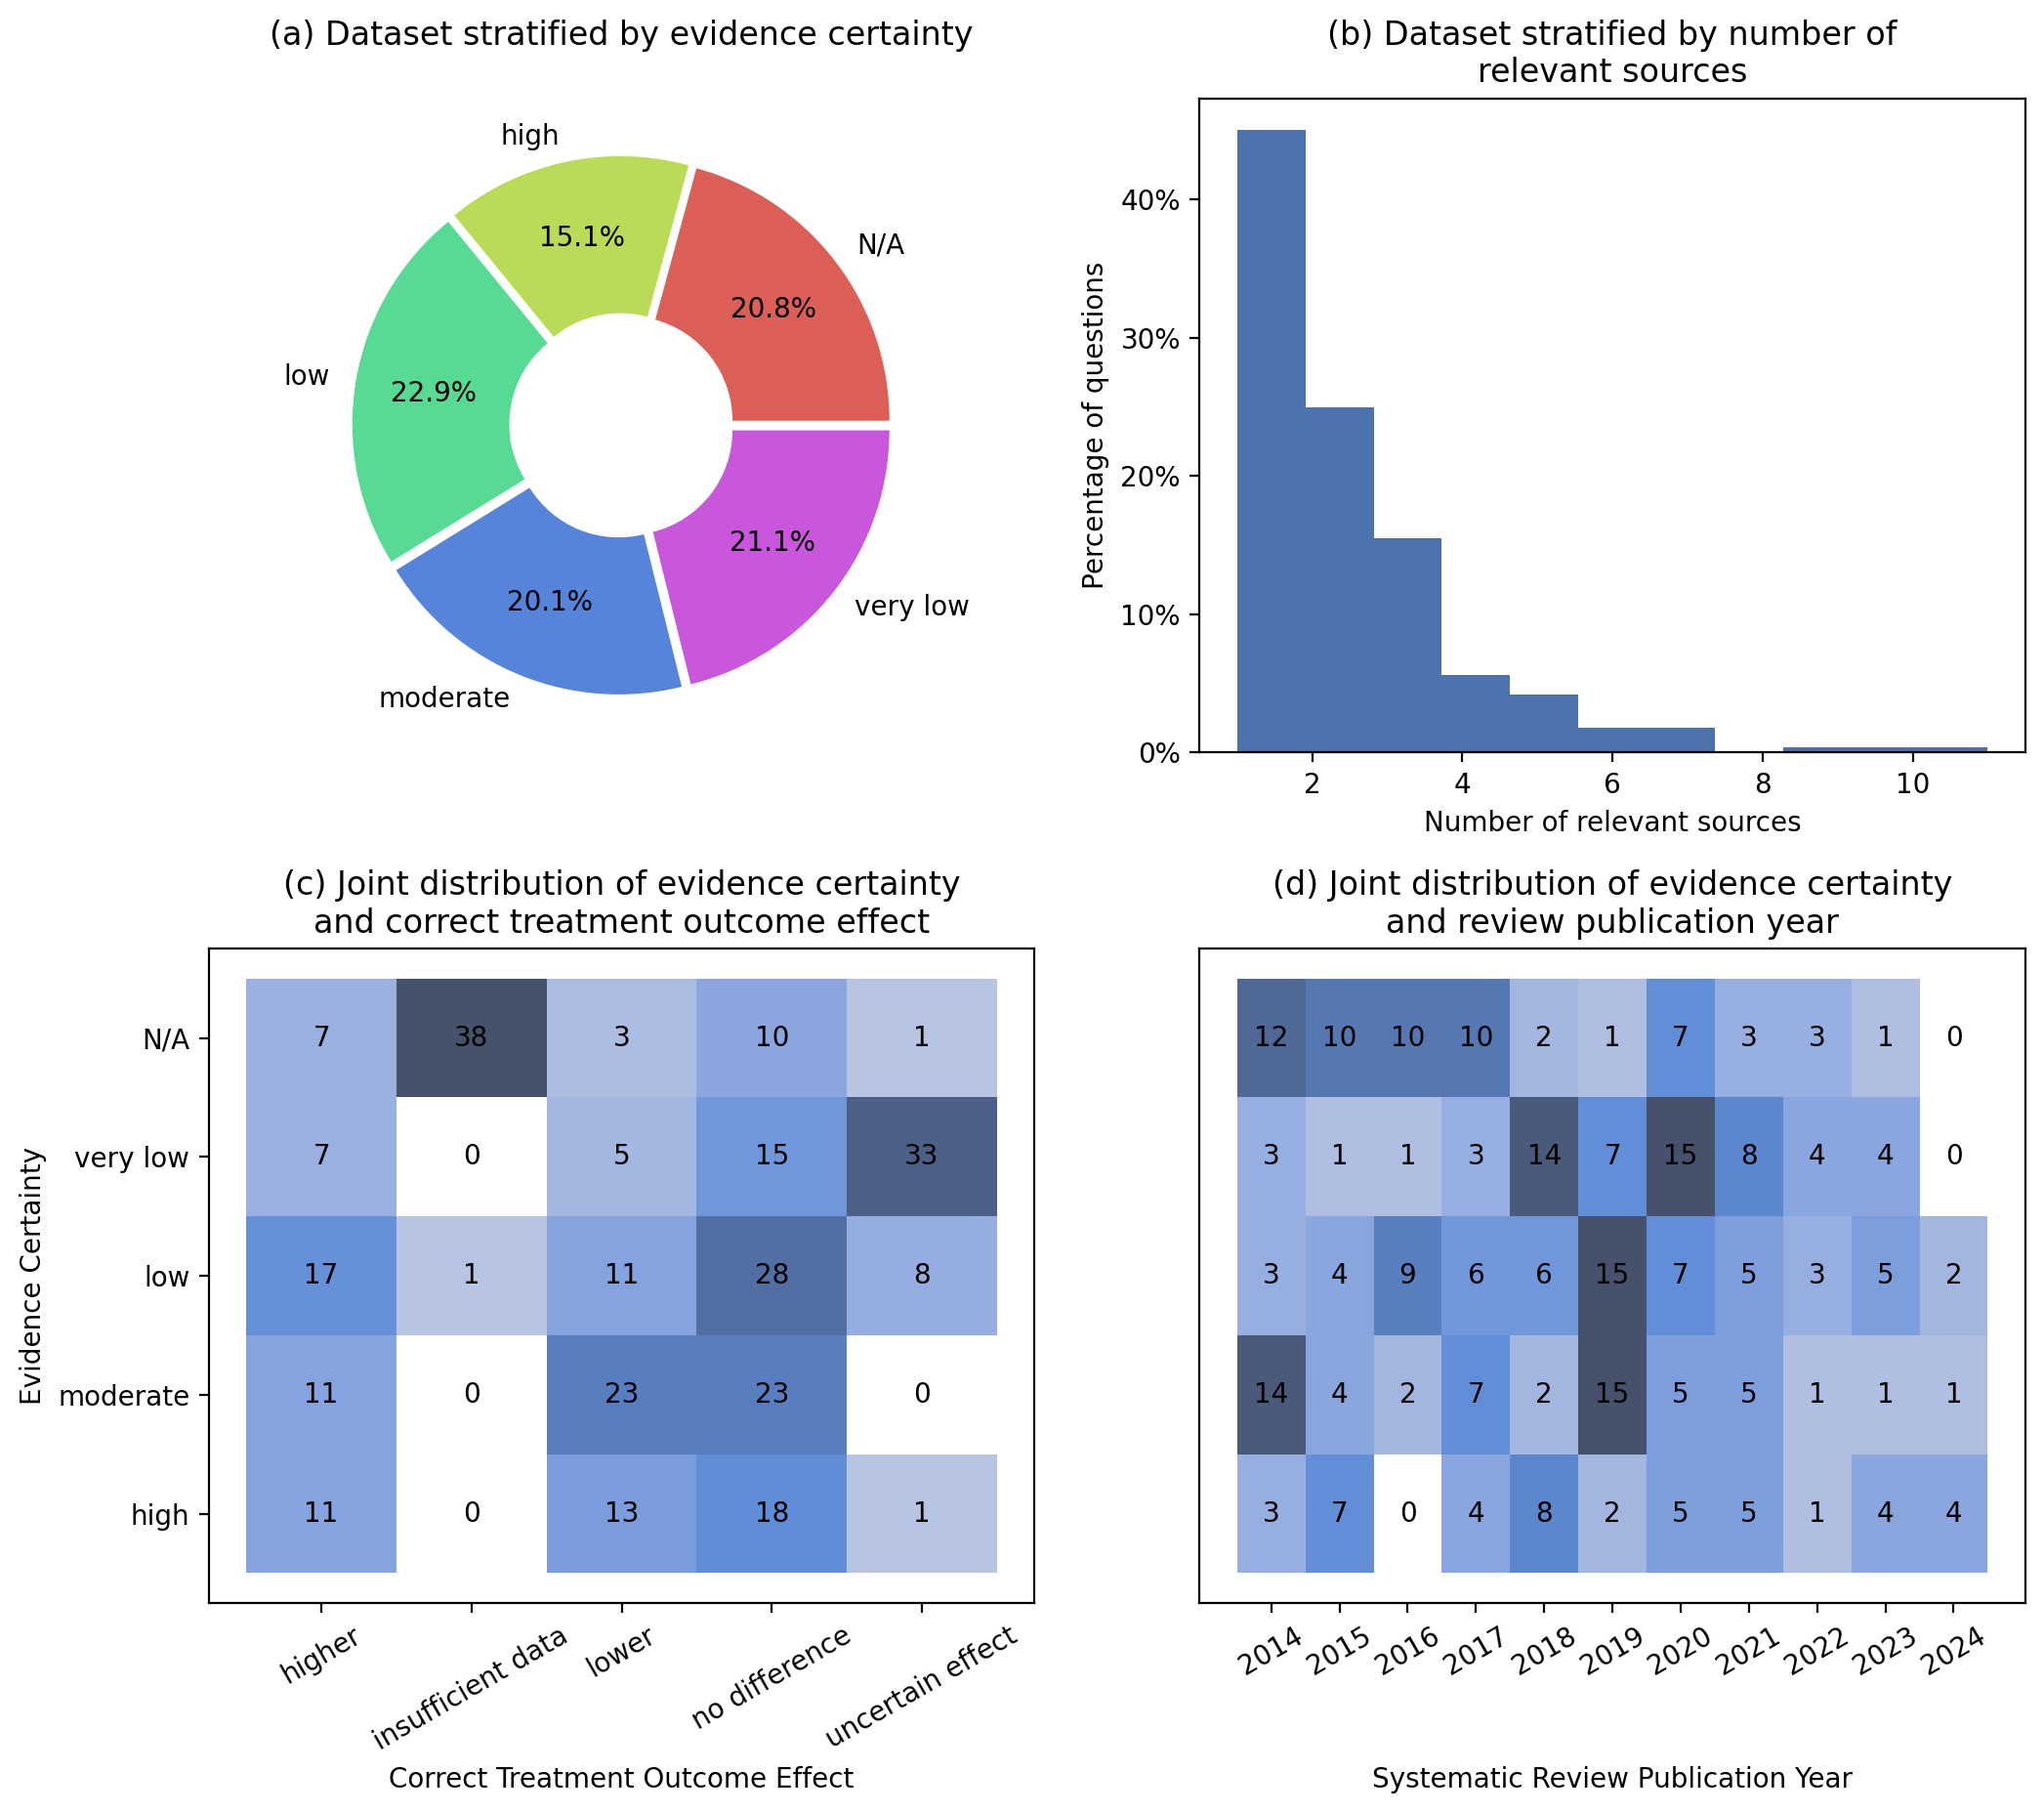

In [680]:
def annotate(ax):
    mesh = ax.collections[0]
    R, C, _ = mesh.get_coordinates().data.shape
    delta = (mesh.get_coordinates()[0,1,0] - mesh.get_coordinates()[0,0,0])/2
    for i in range(R-1):
        for j in range(C-1):
            count = ax.collections[0]._A.data[i,j]
            ax.annotate(str(int(count)), (j,i), ha='center', va='center')

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,10), dpi=200)
pal = sns.color_palette('hls', n_colors=5)
eq = setupdf.groupby('evidence_quality').agg({'question_id':'count'})
donut_plot(ax[0,0], data=eq.values.flatten(), labels=eq.index, pal=pal, startangle=0, labeldistance=1.1)
ax[0,0].set_title('(a) Dataset stratified by evidence certainty\n')
ax[0,1].hist([len(x) for x in setupdf.relevant_sources], bins=11, weights=np.ones(len(setupdf)) / len(setupdf))
ax[0,1].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax[0,1].set_title('(b) Dataset stratified by number of\nrelevant sources')
ax[0,1].set_xlabel('Number of relevant sources')
ax[0,1].set_ylabel('Percentage of questions')

qual_order = ['N/A'] + EVIDENCE_QUALITIES
eqdf = setupdf.groupby('evidence_quality').apply(lambda x: x.sort_values('answer')).loc[qual_order]
sns.histplot(eqdf, x='answer', y='evidence_quality', cbar=False, ax=ax[1,0])
annotate(ax[1,0])
ax[1,0].set_title('(c) Joint distribution of evidence certainty\nand correct treatment outcome effect')
ax[1,0].set_xlabel('Correct Treatment Outcome Effect')
ax[1,0].set_ylabel('Evidence Certainty')
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=30)

yeardf = setupdf.groupby('evidence_quality').apply(lambda x: x.sort_values('review_year')).loc[qual_order]
sns.histplot(yeardf, x='review_year', y='evidence_quality', cbar=False, ax=ax[1,1])
annotate(ax[1,1])
ax[1,1].axes.get_yaxis().set_visible(False)
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=30)
ax[1,1].set_title('(d) Joint distribution of evidence certainty\nand review publication year')
ax[1,1].set_xlabel('Systematic Review Publication Year')
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=30)
fig.align_xlabels()
fig.subplots_adjust(hspace=0.3)
fig.savefig('appendiximgs/extra_dataDistrib.pdf', bbox_inches='tight')

/var/folders/cp/ps4v9yh52dj0wy2dnwf912cr0000gn/T/ipykernel_26198/2535396693.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


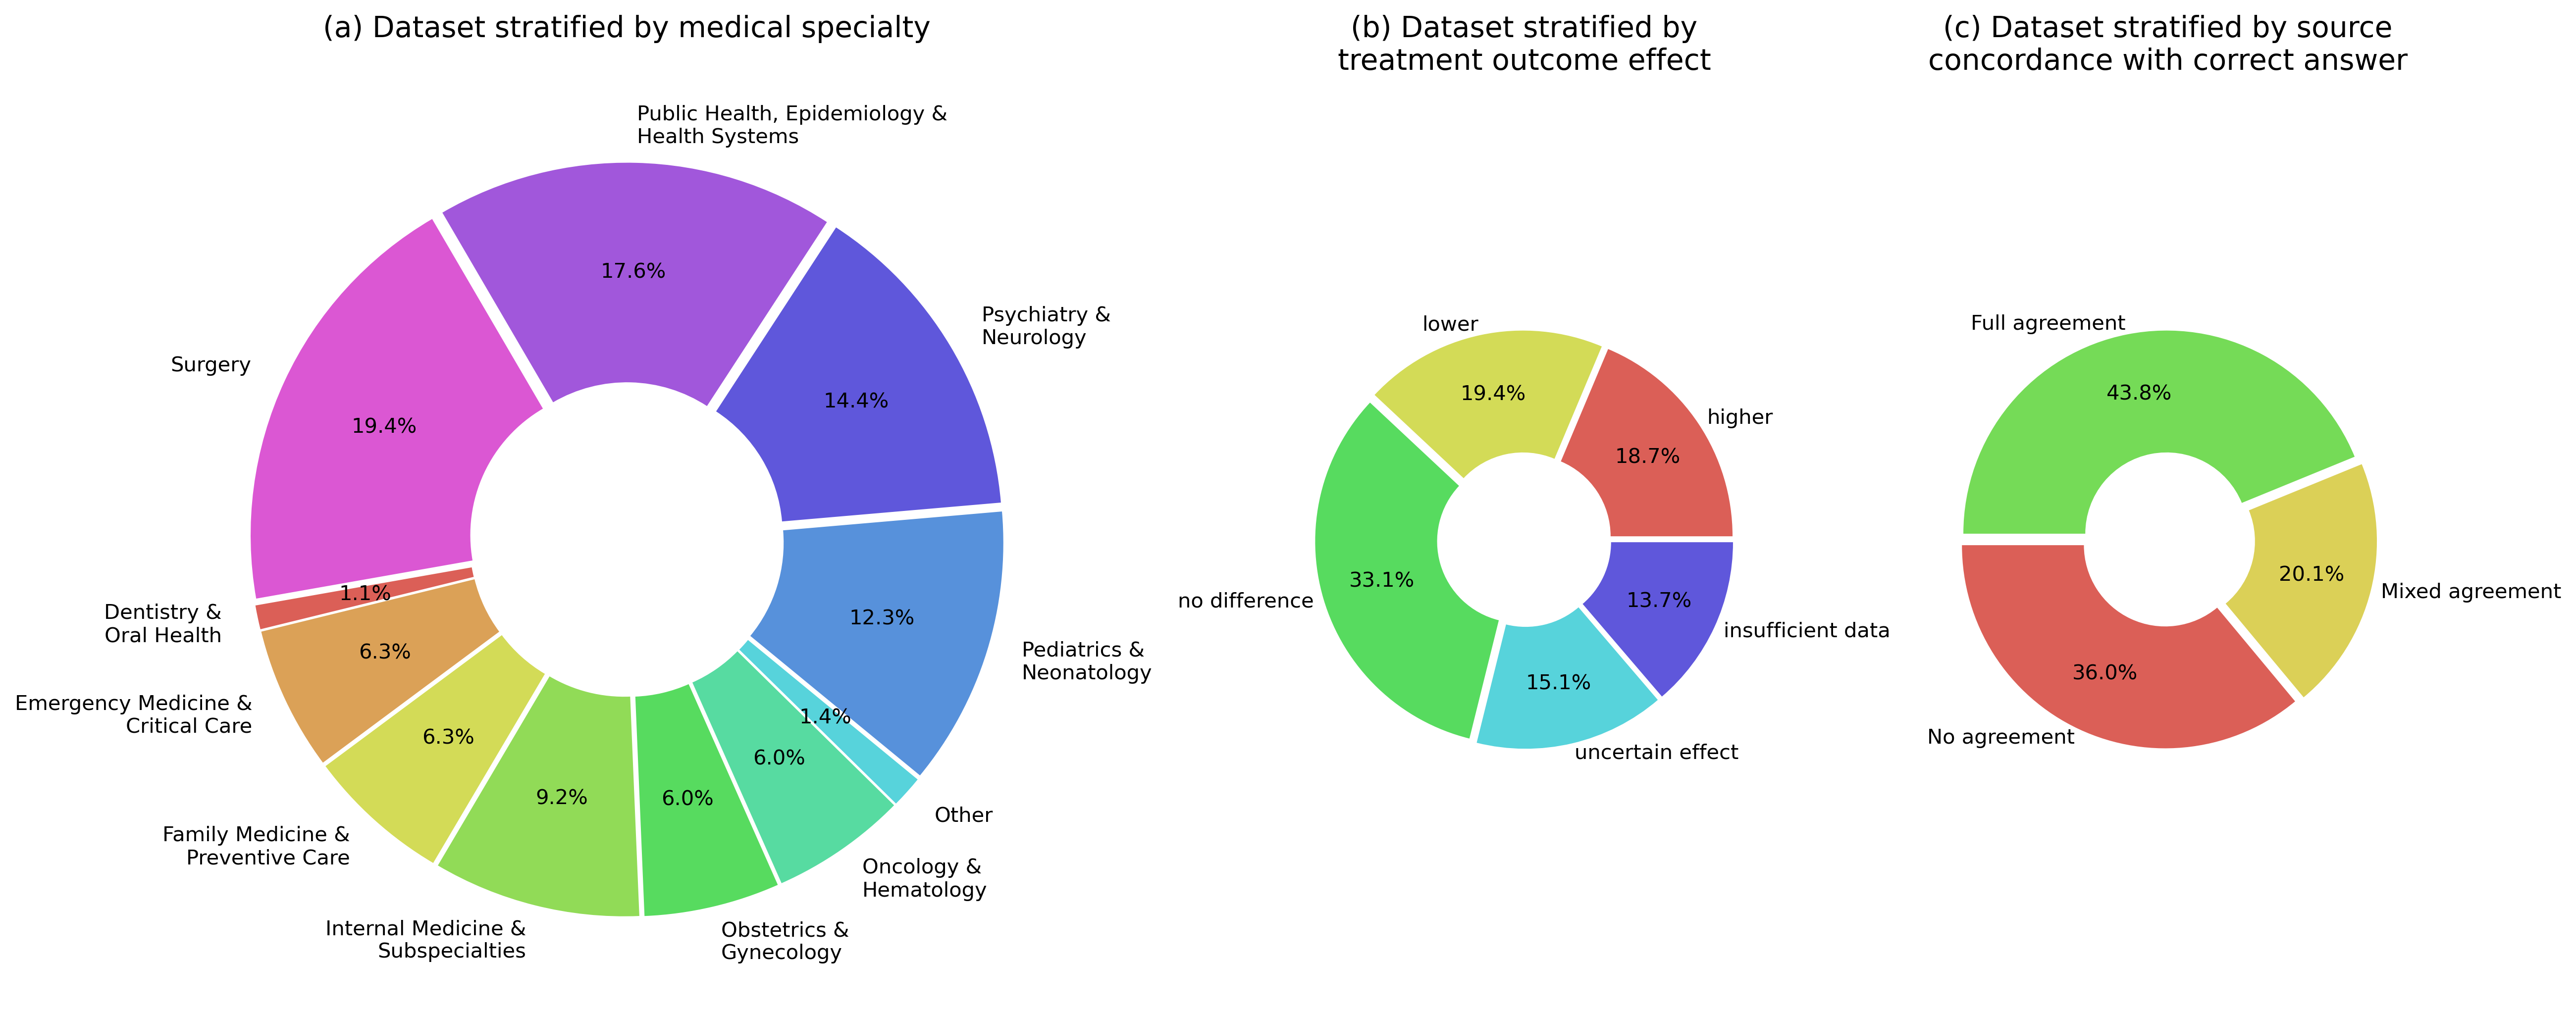

In [550]:
TITLE_SIZE = 14
pal = sns.color_palette('hls', n_colors=12)
fig, ax = plt.subplots(ncols=3, width_ratios=[2, 1, 1], figsize=(20,8), dpi=300)

setupdf['_med'] = setupdf['med_specialty'].str.replace('& ', '&\n')
med_distrib = setupdf.groupby('_med').agg({'question_id': 'count'})#.drop('Other')
donut_plot(ax[0], data=med_distrib.values.flatten(), labels=med_distrib.index, pal=pal, startangle=190, labeldistance=1.1)
ax[0].set_title('(a) Dataset stratified by medical specialty\n', fontsize=TITLE_SIZE)

label_distrib = setupdf.groupby('answer').agg({'question_id': 'count'})
pal = sns.color_palette('hls', n_colors=6)
label_distrib = label_distrib.loc[['higher', 'lower', 'no difference', 'uncertain effect', 'insufficient data']]
donut_plot(ax[1], data=label_distrib.values.flatten(), labels=label_distrib.index, pal=pal, labeldistance=1.05)
ax[1].set_title('(b) Dataset stratified by\ntreatment outcome effect', fontsize=TITLE_SIZE)

sla_bins = [(setupdf.sla.values < 0.1).sum(),
            ((setupdf.sla.values > 0.1) & (setupdf.sla.values < 0.99)).sum(),
            (setupdf.sla.values > 0.99).sum()]
pal = sns.color_palette('hls', n_colors=7)
sla_labels = ['No agreement', 'Mixed agreement', 'Full agreement']
donut_plot(ax[2], sla_bins, sla_labels, pal=pal, labeldistance=1.05, startangle=180)
ax[2].set_title('(c) Dataset stratified by source\nconcordance with correct answer', fontsize=TITLE_SIZE)

fig.align_titles()
# fig.suptitle('Question distributions\n', fontsize=TITLE_SIZE+5)

# ax[2].tick_params(axis='x', labelrotation=30)
fig.show()
# fig.savefig('figs/datasetDistrib.pdf')

### final figure plots

#### define funcs

In [ ]:

import ast
setupdf = pd.read_csv('run-med-evidence/___res/dataset_stats.csv')#.drop(columns=['question', 'answer'])
setupdf.loc[:,'relevant_sources'] = setupdf['relevant_sources'].apply(ast.literal_eval)
setupdf['review_pmid'] = setupdf['review_pmid'].astype(str)
setupdf['review_year'] = setupdf['review_year'].apply(lambda x: str(int(x)))
setupdf.loc[:, 'evidence_quality'] = setupdf['evidence_quality'].fillna('N/A')
setup_dict = setupdf.set_index('question_id').T.to_dict()
setupdf


,question_id,question,answer,evidence_quality,fulltext_required,comment,relevant_sources,review_pmid,sla,context_tokens,med_specialty,review_year
0,0,Is the long-term rate of overall lymphocyst fo...,no difference,high,no,NaN,[17466514],28660687,1.000000,287,Surgery,2017
1,1,Is the short-term rate of overall lymphocyst f...,no difference,moderate,no,NaN,"[9190979, 12214830]",28660687,0.500000,608,Surgery,2017
2,2,Is the rate of clinician impression of cogniti...,higher,high,no,NaN,"[15534239, 21519001]",25734590,0.500000,669,Psychiatry & Neurology,2015
3,3,Is the rate of patient self-reported impressio...,uncertain effect,high,no,NaN,"[15534239, 21519001]",25734590,0.000000,669,Psychiatry & Neurology,2015
4,4,Is the number of people with at least one neop...,higher,N/A,no,NaN,"[12196768, 16527699, 21159889, 16767577]",27056645,0.250000,1610,Internal Medicine & Subspecialties,2016
...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,"Is radiographic progression higher, lower, or ...",insufficient data,N/A,no,NaN,"[16947627, 18625622, 19560810]",28282491,1.000000,13073,Internal Medicine & Subspecialties,2017
246,246,"Is patient function measured by HAQ higher, lo...",insufficient data,N/A,no,NaN,"[16162882, 12115176, 24972708]",28282491,0.666667,1307,Internal Medicine & Subspecialties,2017
247,247,"Is radiographic progression higher, lower, or ...",insufficient data,N/A,no,NaN,"[16162882, 12115176, 24972708]",28282491,1.000000,1307,Internal Medicine & Subspecialties,2017
248,248,"Is cancer risk higher, lower, or the same when...",insufficient data,N/A,no,NaN,"[16162882, 12115176, 24972708]",28282491,1.000000,1307,Oncology & Hematology,2017


In [3]:
def bin_n_source(n):
    if n < 4:
        return str(n)
    else:
        return "4+"

def bin_sla_pct(x):
    if x < 0.1:
        return "0%"
    elif x < 0.5:
        return "1-49%"
    elif x == 0.5:
        return "50%"
    elif x < 1:
        return "51-99%"
    else:
        return "100%"

NSOURCE_BINS = ["1", "2", '3', "4+"]
ANSWER_CLASSES = ["higher", "lower", "no difference", "insufficient data", "uncertain effect"]
EVIDENCE_QUALITIES = ["very low", "low", "moderate", "high"]
DEFAULT_ANS = "invalid"
SOURCE_AGREEMENT_PCT_BINS = ['0%', '1-49%', '50%', '51-99%', '100%']

def grade(filepath):
    with open(filepath, 'r') as fh:
        outputs = [json.loads(line) for line in fh]
    eval_data = []
    
    for out in outputs:
        qid = out['question_id']
        setup = setup_dict[qid]
        model_ans = out.get('parsed_answer')
        ans = model_ans.get('answer', "").lower().strip() if isinstance(model_ans, dict) else ""
        # for ac in ANSWER_CLASSES:
        #     if ans.startswith(ac):
        #         ans = ac
        #         break
        score = (out['gt_answer'].lower() == ans)
        n_src_bin = bin_n_source(len(out['gt_relevant_sources']))
        sla_bin = bin_sla_pct(setup['sla'])
        eval_data.append({
            "question_id": qid,
            "review_id": out['original_review'],
            "question": out['question'],
            "score": score,
            "pred_answer": ans,
            "correct_answer": out['gt_answer'],
            "evidence_quality": out['gt_evidence_quality'],
            "review_pmid": out['original_review'],
            "n_sources": n_src_bin, # "no" if out['gt_answer'] == 'insufficient data' else 
            "fulltext_required": out['gt_fulltext_required'],
            "pred_reasoning": model_ans,
            "sla_bin": sla_bin,
            "review_year": setup['review_year']
        })
    eval_df = pd.DataFrame(eval_data)
    eval_df.loc[:, 'evidence_quality'] = eval_df.evidence_quality.replace('', "n/a")
    eval_df.loc[~eval_df.pred_answer.str.lower().isin(ANSWER_CLASSES), 'pred_answer'] = DEFAULT_ANS
    return eval_df

In [4]:
def make_df(basepath, output_files, warn_missing=False):
    data = []
    for (modelname, display_name, model_series, is_reasoning, model_size, is_medical) in output_files:
        filepath = basepath.format(MODEL=modelname)
        if not os.path.exists(filepath) and warn_missing:
            print(f"WARNING: {modelname} is missing, continuing")
            continue
        eval_df = grade(filepath)
        row = {
            "Model": display_name,
            "Reason Type": "Reasoning" if is_reasoning else "Non-Reasoning",
            "is_medical": is_medical,
            "Model Size": model_size if model_size > 0 else None,
            "Model Series": model_series or display_name,
            "Accuracy": eval_df.score.mean()
        }
        
        evlevel_df = eval_df.groupby("evidence_quality").agg(
            accuracy=pd.NamedAgg(column="score", aggfunc="mean"),
            n_correct=pd.NamedAgg(column="score", aggfunc="sum"),
            n_questions=pd.NamedAgg(column="question", aggfunc="count")
        ).sort_values("accuracy").astype({"n_correct": int, "n_questions": int})
        for evq in EVIDENCE_QUALITIES:
            row[evq] = evlevel_df.loc[evq, "accuracy"]
        
        correct_df = eval_df.groupby("correct_answer").agg(
            accuracy=pd.NamedAgg(column="score", aggfunc="mean"),
            n_correct=pd.NamedAgg(column="score", aggfunc="sum"),
            n_questions=pd.NamedAgg(column="question", aggfunc="count")
        ).sort_values("accuracy").astype({"n_correct": int, "n_questions": int})
        for cor_ans in ANSWER_CLASSES:
            row[cor_ans] = correct_df.loc[cor_ans, "accuracy"]
        
        preds = (eval_df.groupby("pred_answer").agg({"question": "count"}) / len(eval_df))['question'].to_dict()
        row['valid'] = 1 - preds.get('invalid', 0)
        
        nsrc_df = eval_df.groupby("n_sources").agg(
            accuracy=pd.NamedAgg(column="score", aggfunc="mean"),
            n_correct=pd.NamedAgg(column="score", aggfunc="sum"),
            n_questions=pd.NamedAgg(column="question", aggfunc="count")
        ).sort_values("accuracy").astype({"n_correct": int, "n_questions": int})
        for nbin in NSOURCE_BINS:
            row[nbin] = nsrc_df.loc[nbin, "accuracy"]
        
        sla_df = eval_df.groupby("sla_bin").agg(
            accuracy=pd.NamedAgg(column="score", aggfunc="mean"),
            n_correct=pd.NamedAgg(column="score", aggfunc="sum"),
            n_questions=pd.NamedAgg(column="question", aggfunc="count")
        ).sort_values("accuracy").astype({"n_correct": int, "n_questions": int})
        for sla_bin in SOURCE_AGREEMENT_PCT_BINS:
            row[sla_bin] = sla_df.loc[sla_bin, "accuracy"]
        
        data.append(row)

    df = pd.DataFrame(data).sort_values(['Accuracy', 'Model'])
    palette = sns.color_palette("Spectral", n_colors=len(df))
    return df, palette

In [5]:
def make_long_df(basepath, outfiles):
    dfs = []
    for (modelname, display_name, model_series, is_reasoning, model_size, is_medical) in outfiles:
        filepath = basepath.format(MODEL=modelname)
        eval_df = grade(filepath)
        eval_df["Model"] = display_name
        eval_df["Reason Type"] = "Reasoning" if is_reasoning else "Non-Reasoning"
        eval_df['is_medical'] = is_medical
        eval_df["Model Size"] = model_size if model_size > 0 else None
        eval_df["Model Series"] = model_series or display_name
        acc = eval_df.score.mean()
        eval_df["Accuracy"] = acc
        dfs.append(eval_df)
    long_df = pd.concat(dfs).sort_values(['Accuracy', 'Model'])
    model_order = long_df[long_df['question_id'] == 0][['Model', 'is_medical', 'Reason Type']].reset_index(drop=True)
    palette = sns.color_palette("Spectral", n_colors=len(model_order))
    _df_2 = long_df.copy(deep=True)
    _df_2["Model"] = "Average"
    _df_2["is_medical"] = 0
    _df_2["Reason Type"] = "Average"
    catdf = pd.concat([long_df, _df_2])
    avg_palette = palette + ['black']

    N_QUANTILES = 5
    token_data = setupdf.sort_values('context_tokens')[['question_id', 'context_tokens']]
    token_data['ix'] = np.arange(len(token_data))
    token_data['token_bin'] = (token_data['ix'] * N_QUANTILES)//len(token_data)
    threshs = np.linspace(0,100,N_QUANTILES+1).astype(int)
    def qtile(i):
        raw_val = np.quantile(token_data['context_tokens'], threshs[i]/100)/1000
        return np.round(raw_val, 1) if raw_val < 1 else np.round(raw_val).astype(int)
    bin_names = [f"{threshs[i]}-{threshs[i+1]}%\n(~{qtile(i)}-{qtile(i+1)}K)" for i in range(N_QUANTILES)]
    token_data['token_bin'] = token_data['token_bin'].map(dict(zip(range(N_QUANTILES), bin_names)))
    token_data['token_bin'] = pd.Categorical(token_data['token_bin'], categories=bin_names, ordered=True)
    catdf['token_bin'] = None
    long_df['token_bin'] = None
    catdf = catdf.merge(token_data[['question_id', 'token_bin']], on='question_id')
    catdf = catdf.merge(setupdf[['question_id', 'med_specialty']], on='question_id', how='left')
    long_df = long_df.merge(token_data[['question_id', 'token_bin']], on='question_id')
    long_df = long_df.merge(setupdf[['question_id', 'med_specialty']], on='question_id', how='left')
    return long_df, palette, model_order, catdf, avg_palette

In [6]:
def pub_year_acc(ax, _df, pal):
    order = model_order.Model.values.tolist()+['Average']
    _df = _df.groupby('Model').apply(lambda x: x.sort_values('review_year')).loc[order]
    sns.lineplot(_df, x='review_year', y='score', hue='Model', style='Reason Type', palette=pal, 
                ax=ax, errorbar=None, markers='.', markersize=10)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.8), ncol=3)
    ax.set_xlabel('Systematic Review Publication Year')
    ax.set_ylabel('Accuracy')

In [14]:
# now in long_df mode
def percent_valid_plot(ax, df, pal):
    # percent valid
    df['valid'] = (df.pred_answer != 'invalid')
    sns.barplot(df, x='valid', y='Model', ax=ax, errorbar=None, orient='y', color='darkgrey')
    sns.barplot(df, x='score', y='Model', hue='Model', palette=pal, ax=ax,
                errorbar=('ci', 95), n_boot=1000, err_kws=dict(linewidth=1, color='#000000'), capsize=0.3)
    # sns.barplot(df, x='score', y='Model', ax=ax, errorbar=None, orient='y', hue='Model', palette=pal)
    for i, bar in enumerate(ax.patches[-len(model_order):]):
        if model_order.iloc[i].is_medical:
            bar.set_edgecolor('black')
            bar.set_linewidth(2)
        if model_order.iloc[i]['Reason Type'] == 'Reasoning':
            bar.set_hatch('//')
    legend_elements = [
        Patch(facecolor='darkgrey', hatch='', label=f'Valid Output'),
        Patch(facecolor='lightblue', hatch='//', label=f'Reasoning'),
        Patch(facecolor='lightblue', hatch='', label=f'Non-Reasoning'),
        Patch(facecolor='lightblue', edgecolor='black', linewidth=2, hatch='', label=f'Medically Finetuned'),
    ]
    ax.set_xlim(0, 1)
    ax.set_ylabel('')
    ax.set_xlabel('Percentage Parsable Outputs vs Correct Outputs')

    ax.legend(handles=legend_elements)

In [8]:
def evidence_quality_plot(ax, df, pal):
    # by evidence quality
    # evqual_df = df.set_index('Model')[EVIDENCE_QUALITIES]
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Evidence Certainty Level")
    # sns.lineplot(evqual_df.T, ax=ax, palette=pal, dashes=False, markers='.', markersize=MSIZE)
    # ax.plot(evqual_df.mean().values, label="Average", color='k', linestyle='--', linewidth='2', marker='.', markersize=MSIZE-2)
    df = df[df.evidence_quality.isin(EVIDENCE_QUALITIES)]
    df['srt_evidence_quality'] = pd.Categorical(df['evidence_quality'], categories=EVIDENCE_QUALITIES, ordered=True)
    sns.lineplot(df, x='srt_evidence_quality', y='score', hue='Model', style='Reason Type', palette=pal, 
                ax=ax, errorbar=None, markers='.', markersize=10)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.75), ncol=3)
    ax.set_ylim(0,1)

In [9]:
def percent_source_agreement_plot(ax, df, pal, plot_type='line'):
    assert plot_type in ['line', 'bar']
    # by % source-level agreement
    xname = 'Percentage of Individual Sources Matching the Correct Answer (binned)'
    ######## lineplot
    # _df = df.set_index('Model')[SOURCE_AGREEMENT_PCT_BINS]
    # ax.set_ylabel("Accuracy")
    ax.set_xlabel(xname)
    # sns.lineplot(_df.T, ax=ax, palette=pal, dashes=False, markers='.', markersize=MSIZE)
    # ax.plot(_df.mean().values, label="Average", color='k', linewidth='2', marker='.', markersize=MSIZE-2)
    df = df[df.sla_bin.isin(SOURCE_AGREEMENT_PCT_BINS)]
    df['srt_sla_bin'] = pd.Categorical(df['sla_bin'], categories=SOURCE_AGREEMENT_PCT_BINS, ordered=True)
    sns.lineplot(df, x='srt_sla_bin', y='score', hue='Model', style='Reason Type', palette=pal, 
            ax=ax, errorbar=None, markers='.', markersize=10)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.75), ncol=3)
    ax.set_ylim(0,1)

In [10]:
def num_sources_plot(ax, df, pal):
    # by number of sources
    order = model_order.Model.values.tolist()+['Average']
    _df = df.groupby('Model').apply(lambda x: x.sort_values('n_sources')).loc[order]
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of Sources")
    sns.lineplot(_df, x='n_sources', y='score', hue='Model', style='Reason Type', palette=pal, 
        ax=ax, errorbar=None, markers='.', markersize=10)
    # sns.lineplot(nsource_df.T, ax=ax, palette=pal, dashes=False)
    # ax.plot(nsource_df.mean().values, label="Average", color='k', linestyle='--', linewidth='2')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.75), ncol=3)
    ax.set_ylim(0,1)

In [103]:
def model_size_plot(ax, df, pal='hls'):
    pal = 'hls'
    # this is hardcoded and wrong lol
    # med_pal = [(0.86, 0.33999999999999997, 0.6207999999999999), (0.33999999999999997, 0.86, 0.5792000000000002)]
    ## lines
    for v in [7, 32, 70]:
        ax.axvline(v, linestyle='--', color='black', linewidth=1, zorder=-10)
        ax.annotate(str(v)+"B", xy=(v+3, 0.8), rotation=90)
    ### plot
    # df['not_medical'] = ~df.is_medical
    size_df = df.dropna().sort_values('is_medical', ascending=False)
    sns.lineplot(size_df, x='Model Size', y='Accuracy', hue='Model Series', ax=ax, legend=False, palette=pal)
    sns.scatterplot(size_df, x='Model Size', y='Accuracy', hue='Model Series', palette=pal,
    #                 style='Reason Type', style_order=['Non-Reasoning', 'Reasoning'], ec='black', linewidth=2,s=80)
    # sns.scatterplot(size_df[size_df.is_medical < 1], x='Model Size', y='Accuracy', hue='Model Series', palette=pal,
                    style='Reason Type', style_order=['Non-Reasoning', 'Reasoning'], s=80, ax=ax)
    ax.set_ylim(0,1)
    ax.set_xlabel("Model Size (B)")
    # print(len(ax.collections))
    path_col = ax.collections[-1]
    n_med = df.is_medical.sum()
    path_col.set_edgecolors(['black' if i < n_med else 'white' for i in range(len(path_col.get_paths()))])
    path_col.set_linewidths([2 if i < n_med else 0 for i in range(len(path_col.get_paths()))])
    # for path in enumerate():
    #     if i > 12:
    #         col.set_edgecolors('black')
    #         col.set_linewidths(3)
    ## legend
    handles, labels = ax.get_legend_handles_labels()
    handles[-2].set_markerfacecolor('grey')
    handles[-1].set_markerfacecolor('grey')
    handles.append(Line2D([],[], linewidth=0, marker='.', markersize=15, markeredgecolor='black', markerfacecolor='grey', markeredgewidth=2))
    labels.append('Medical')
    ax.legend(handles[1:-4]+handles[-3:], labels[1:-4]+labels[-3:], loc='center right', bbox_to_anchor=(1.5, 0.5), frameon=False)

In [12]:
def conf_mat(eval_df):
    conf_mat_data = []
    pred_cls = ANSWER_CLASSES + ['invalid']
    gt_cls = ANSWER_CLASSES
    for c_label in gt_cls:
        row = []
        c_label_mask = eval_df.correct_answer.str.lower() == c_label
        for p_label in pred_cls:
            p_label_mask = eval_df.pred_answer.str.lower() == p_label
            row.append((c_label_mask & p_label_mask).sum())
        conf_mat_data.append(row)
    conf_mat = pd.DataFrame(conf_mat_data, columns=pred_cls, index=gt_cls)
    return conf_mat

#### run stuff

In [ ]:
# df_basic,_ = make_df("run-med-evidence/___res/{MODEL}_closed_barebones_fulltext.jsonl", outfiles)
# df_basic = df_basic[['Model', 'Accuracy']]
# df_expguided,_ = make_df("run-med-evidence/___res/{MODEL}_closed.jsonl", outfiles)
# df_expguided = df_expguided[['Model', 'Accuracy']]

# joint = df_basic.merge(df_expguided, on='Model', suffixes=(' (Basic)', ' (Expert Guided)'))
# joint["Diff (expert-basic)"] = joint["Accuracy (Expert Guided)"] - joint['Accuracy (Basic)']
# joint

In [13]:
outfiles = [
    # format: (model, display name, model_series, is_reasoning, model_size in B, is_medical) [-1 = do not include]
    ("deepseekR1", "DeepSeek R1", '', 1, 671, 0),
    ("deepseekV3", "DeepSeek V3", '', 0, 671, 0),
    ("gpt4_1", "GPT-4.1", 'GPT-4.1', 0, -1, 0),
    ("gpt4_1mini", "GPT-4.1 mini", 'GPT-4.1', 0, -1, 0),
    ("gpto1", "GPT-o1", '', 1, -1, 0),
    ("huatuo7b", "HuatuoGPT-o1-7B", '', 1, 6.99, 1),
    ("huatuo70b", "HuatuoGPT-o1-70B", '', 1, 69.99, 1),
    ("llama3_1_8b", "Llama 3.1 8B", 'Llama 3.1', 0, 8, 0),
    ("llama3_1_70b", "Llama 3.1 70B", 'Llama 3.1', 0, 70, 0),
    ("llama3_1_405b", "Llama 3.1 405B", 'Llama 3.1', 0, 405, 0),
    ("llama3_8b", "Llama 3.0 8B", 'Llama 3.0', 0, 8, 0),
    ("llama3_70b", "Llama 3.0 70B", 'Llama 3.0', 0, 70, 0),
    ("llama4mav", "Llama 4 Maverick", 'Llama 4', 0, 400, 0),
    ("llama4scout", "Llama 4 Scout", 'Llama 4', 0, 109, 0),
    ("llama70b_instruct", "Llama 3.3 70B-Instruct", '', 0, 70, 0),
    ("llama70b_r1distill", "Llama 3.3 70B (R1-Distill)", '', 1, 70, 0),
    ("openbiollm_8b", "OpenBioLLM 8B", '', 0, 7.99, 1),
    ("openbiollm_70b", "OpenBioLLM 70B", '', 0, 69.99, 1),
    ("openthinker2_32b", "OpenThinker2-32B", '', 1, 32, 0),
    ("qwen3_235b", "Qwen3-235B-A22B-FP8", '', 1, 235, 0),
    ("qwen7b", "Qwen2.5-7B-Instruct", 'Qwen2.5', 0, 7, 0),
    ("qwen32b", "Qwen2.5-32B-Instruct", 'Qwen2.5', 0, 32, 0),
    ("qwen72b", "Qwen2.5-72B-Instruct", 'Qwen2.5', 0, 72, 0),
    ("qwq32b", "QwQ-32B", '', 1, 32, 0),
]

analysis_sets = [
    ("Fulltext", "run-med-evidence/___res/{MODEL}_closed_barebones_fulltext.jsonl"),
    ("Abstract", "run-med-evidence/___res/{MODEL}_closed_barebones_abstract.jsonl"),
    # ("Expert-Guided", "run-med-evidence/___res/{MODEL}_closed.jsonl")
]
basepath = analysis_sets[0][1]
long_df, palette, model_order, catdf, avg_palette = make_long_df(basepath, outfiles)

/var/folders/cp/ps4v9yh52dj0wy2dnwf912cr0000gn/T/ipykernel_88105/564422106.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  long_df = pd.concat(dfs).sort_values(['Accuracy', 'Model'])


/var/folders/cp/ps4v9yh52dj0wy2dnwf912cr0000gn/T/ipykernel_26198/1172856756.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scores = long_df.groupby('med_specialty').apply(lambda grp: grp.score.mean()).sort_values()
/var/folders/cp/ps4v9yh52dj0wy2dnwf912cr0000gn/T/ipykernel_26198/1172856756.py:6: UserWarning: The palette list has more values (12) than needed (11), which may not be intended.
  sns.barplot(plotdf, ax=ax, y='_med', x='score', hue='_med', palette=pal, #order=scores.index,


Text(0, 0.5, '')

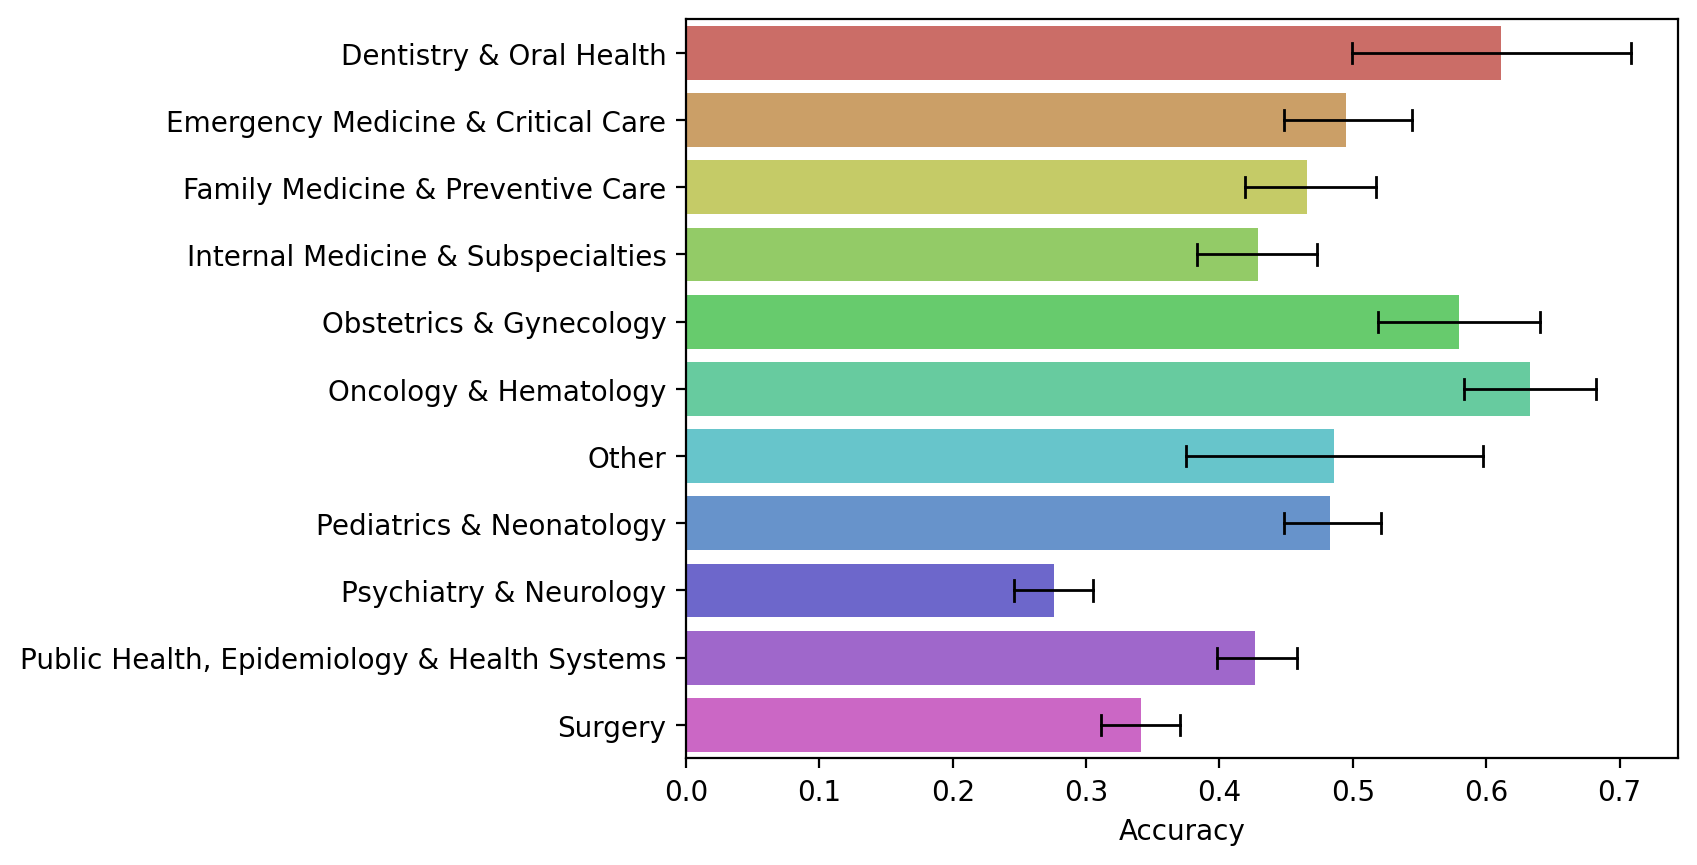

In [621]:
scores = long_df.groupby('med_specialty').apply(lambda grp: grp.score.mean()).sort_values()
fig, ax = plt.subplots(dpi=200)
pal = sns.color_palette('hls', n_colors=12)
plotdf = long_df.sort_values('med_specialty')
plotdf['_med'] = plotdf['med_specialty']#.str.replace('& ', '&\n')
sns.barplot(plotdf, ax=ax, y='_med', x='score', hue='_med', palette=pal, #order=scores.index,
            errorbar=('ci', 95), n_boot=1000, err_kws=dict(linewidth=1, color='#000000'), capsize=0.3)
ax.set_xlabel('Accuracy')
ax.set_ylabel(None)
# fig.savefig('appendiximgs/accByMedSpecialty.pdf', bbox_inches='tight')

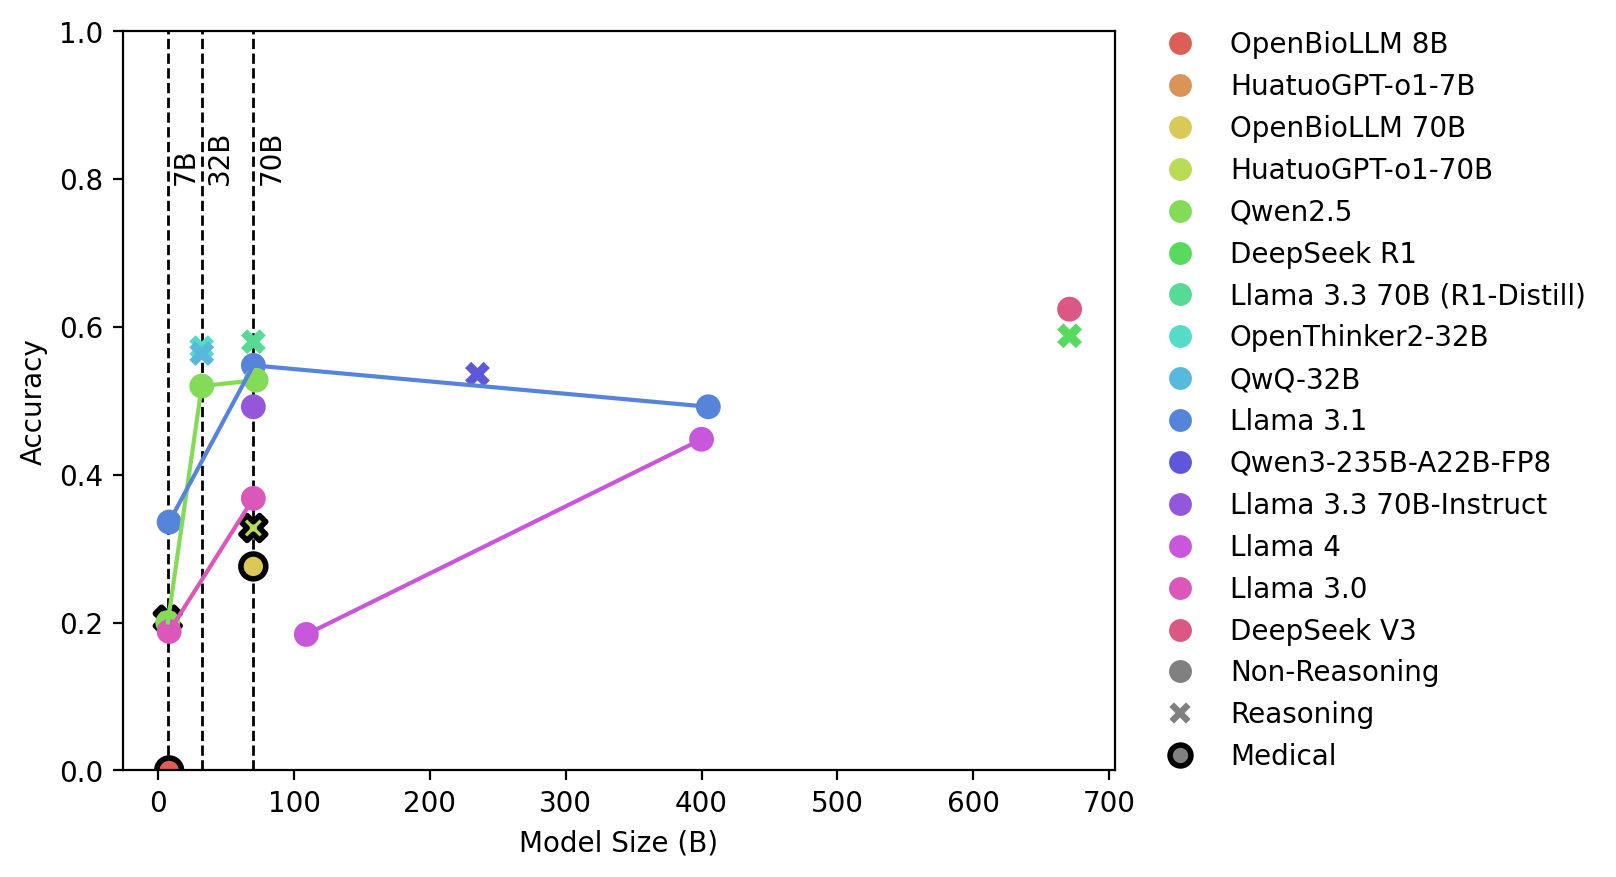

In [104]:
fig, ax = plt.subplots(dpi=200)
df, _ = make_df(basepath, outfiles)
model_size_plot(ax, df)
fig.savefig('appendiximgs/modelSizes.pdf', bbox_inches='tight')

In [ ]:
series = setupdf.groupby('review_year').apply(lambda grp: (grp.evidence_quality == 'high').mean()).reset_index(drop=True)
fig, ax = plt.subplots(dpi=200)
# yeardf = setupdf.groupby('review_year').agg({'question_id': 'count'})
# series = yeardf['question_id']
ax.bar(np.arange(len(series)), series, alpha=0.5)
pub_year_acc(ax, catdf, avg_palette)

In [ ]:
_fig, fake_ax = plt.subplots(figsize=(1,1))
sns.lineplot(catdf, x='token_bin', y='score', hue='Model', style='Reason Type', ax=fake_ax,
            errorbar=None, palette=avg_palette)
handles, labels = fake_ax.get_legend_handles_labels()
fake_ax.legend().set_visible(False)

model_sets = [
    (long_df['Model Size'] < 10, '7-8B'),
    ((long_df['Model Size'] > 10) & (long_df['Model Size'] < 40), '32B'),
    ((long_df['Model Size'] > 40) & (long_df['Model Size'] < 80), '70-72B'),
    ((long_df['Model Size'] > 100), '100B+'),
]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,14), dpi=200)
for i, (mask, mtype) in enumerate(model_sets):
    ax = axs[i//2, i%2]
    _df = long_df[mask]
    # pal = sns.color_palette('husl', n_colors=len(_df.Model.unique()))
    colors = []
    for m in _df.Model.unique():
        ix = model_order.set_index('Model').index.get_loc(m)
        colors.append(palette[ix])
    _df_2 = _df.copy(deep=True)
    _df_2["Model"] = "Average"
    _df_2["is_medical"] = 0
    _df_2["Reason Type"] = "Average"

    _catdf = pd.concat([_df, _df_2])
    _avg_palette = colors + ['black']
    sns.lineplot(_catdf, ax=ax, x='token_bin', y='score', hue='Model', style='Reason Type',
                errorbar=None, palette=_avg_palette, marker='.', markersize=10)
    # ax.plot(evqual_df.mean().values, label="Average", color='k', linestyle='--', linewidth='2')
    # ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3)
    ax.set_xlabel('Total Number of Context Tokens (Quantile Ranges / Raw Tokens)')
    ax.legend('off')
    if i > -1:
        ax.set_ylabel('Accuracy')
    ax.set_title(f'{mtype} models')
    ax.set_ylim(0, 0.7)
    ax.legend().set_visible(False)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=4)
fig.show()
fig.savefig('appendiximgs/tokenCounts_modelSize.pdf', bbox_inches='tight')

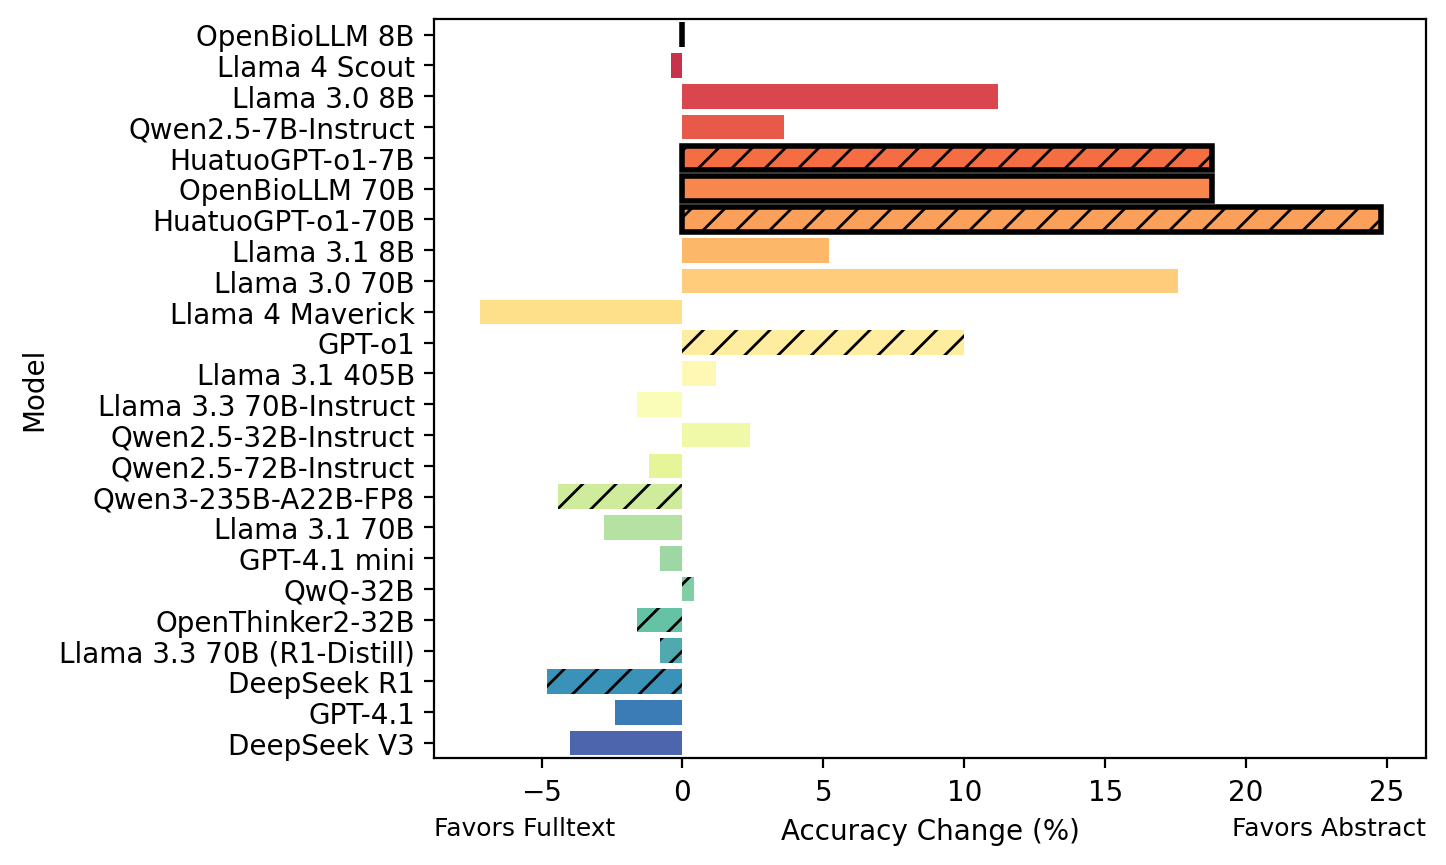

In [628]:
def label_ends(ax, left, right, offset=-25, **kwargs):
    y, _ = ax.get_ylim()
    xL, xR = ax.get_xlim()
    ax.annotate(left,
        xy=(xL, y),
        xytext=(0, offset),
        textcoords="offset points",
        ha="left",
        va="center",
        **kwargs
    )
    ax.annotate(right,
        xy=(xR, y),
        xytext=(0, offset),
        textcoords="offset points",
        ha="right",
        va="center",
        **kwargs
    )


## plot diff between systems
interest_col = 'Accuracy'
join_col = 'Model'
joint = pd.DataFrame()
for name, basepath in analysis_sets:
    _df, _ = make_df(basepath, outfiles, warn_missing=True)
    _df = _df.set_index(join_col)
    joint[name] = _df[interest_col]
joint['delta'] = (joint.iloc[:, 1] - joint.iloc[:,0])*100
joint = joint.reset_index().dropna()
fig, ax = plt.subplots(dpi=200)
sns.barplot(joint, ax=ax, x='delta', y='Model')
ax.set_xlabel("Accuracy Change (%)")
modelmap = model_order.set_index('Model')
for m, bar in zip(joint.Model.values, ax.patches):
    ix = modelmap.index.get_loc(m)
    bar.set_facecolor(palette[ix])
    if model_order.iloc[ix].is_medical:
        bar.set_edgecolor('black')
        bar.set_linewidth(2)
    if model_order.iloc[ix]['Reason Type'] == 'Reasoning':
        bar.set_hatch('//')
label_ends(ax, f"Favors {analysis_sets[0][0]}", f"Favors {analysis_sets[1][0]}", fontsize=9)
# fig.savefig('appendiximgs/basic_vs_expertguided.pdf', bbox_inches='tight')


In [17]:
def main_acc_plot(ax, df):
    sns.barplot(df, x='score', y='Model', hue='Model', palette=palette, ax=ax,
                errorbar=('ci', 95), n_boot=1000, err_kws=dict(linewidth=1, color='#000000'), capsize=0.3)

    for i, bar in enumerate(ax.patches):
        if model_order.iloc[i].is_medical:
            bar.set_edgecolor('black')
            bar.set_linewidth(2)
        if model_order.iloc[i]['Reason Type'] == 'Reasoning':
            bar.set_hatch('//')
    legend_elements = [
        Patch(facecolor='grey', hatch='//', label=f'Reasoning'),
        Patch(facecolor='grey', hatch='', label=f'Non-Reasoning'),
        Patch(facecolor='grey', edgecolor='black', linewidth=2, hatch='', label=f'Medically Finetuned')
    ]
    # ax.set_xlim(0, 1)
    ax.set_xlabel('Overall Accuracy')
    ax.set_ylabel('')

    # Add the legend
    ax.legend(handles=legend_elements)

def avg_recall_plot(ax, df):
    avgs = df[df.Model=='Average']
    sns.barplot(avgs, x='correct_answer', y='score', ax=ax, color='lightgrey', linewidth=1,
                order=['uncertain effect', 'no difference', 'insufficient data', 'higher', 'lower'],
                errorbar=('ci', 95), err_kws=dict(linewidth=1.5, color='#000000'), capsize=0.3)
    ax.set_xlabel('Treatment Outcome Effect')
    ax.set_xticklabels(['Uncertain\nEffect', 'No Difference', 'Insufficient\nData', 'higher', 'lower'], fontsize=8, rotation=30)
    ax.set_ylabel('Average Recall')

/var/folders/cp/ps4v9yh52dj0wy2dnwf912cr0000gn/T/ipykernel_88105/80607571.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Uncertain\nEffect', 'No Difference', 'Insufficient\nData', 'higher', 'lower'], fontsize=8, rotation=30)


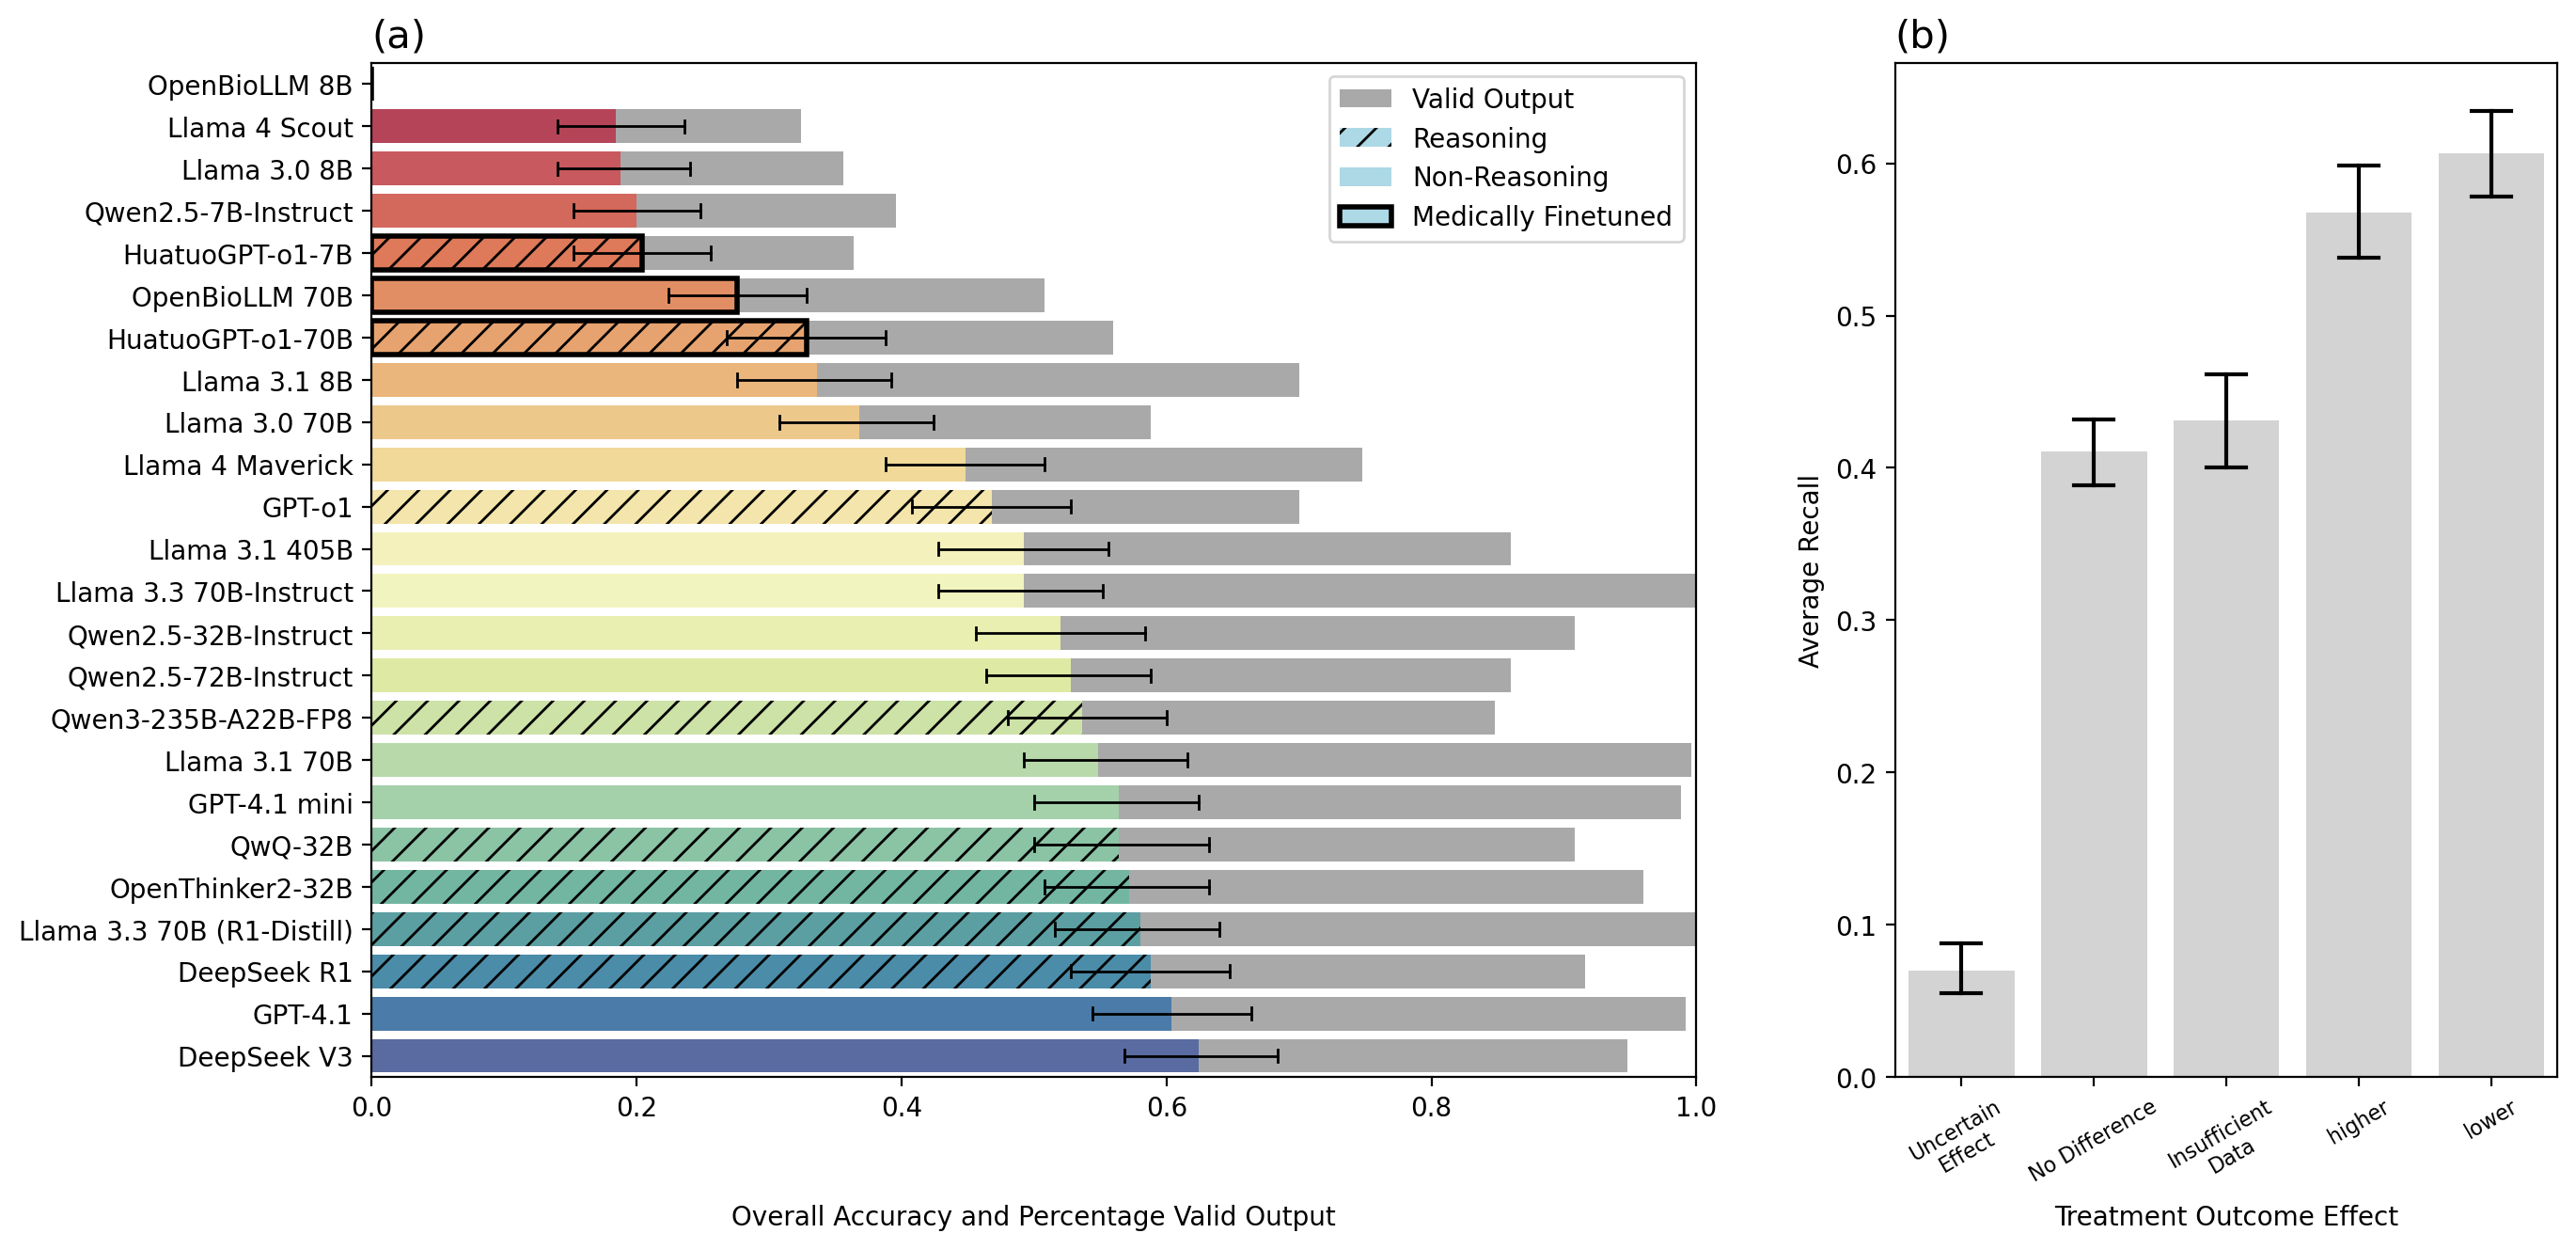

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(15,7), dpi=200, width_ratios=[2,1])
# main_acc_plot(axs[0], long_df)
percent_valid_plot(axs[0], long_df, palette)
avg_recall_plot(axs[1], catdf)
axs[0].set_title('(a)', loc='left', fontsize=15)
axs[0].set_xlabel('Overall Accuracy and Percentage Valid Output')
axs[1].set_title('(b)', loc='left', fontsize=15)
fig.align_xlabels()
fig.savefig(f'[NeuRIPS-2025] MedEvidence Benchmark/img/overallAcc_pctValid_avgRecall.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(dpi=200)
num_sources_plot(ax, catdf, avg_palette)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:-5]+handles[-3:], labels[1:-5]+labels[-3:], loc='lower center', bbox_to_anchor=(0.5, -0.7), ncol=3)
fig.savefig('appendiximgs/nRelevantSources.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(dpi=200)
evidence_quality_plot(ax, catdf, pal=avg_palette)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:-5]+handles[-3:], labels[1:-5]+labels[-3:], loc='lower center', bbox_to_anchor=(0.5, -0.7), ncol=3)
fig.savefig('appendiximgs/expguide_evQuals.pdf', bbox_inches='tight')

In [ ]:
MSIZE = 10
# df, pal = make_df(basepath, outfiles)
fig, ax = plt.subplots(ncols=2, figsize=(15,5), dpi=200)
evidence_quality_plot(ax[0], catdf, pal=avg_palette)
percent_source_agreement_plot(ax[1], catdf, pal=avg_palette)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend().set_visible(False)
ax[0].set_xlabel("Evidence Certainty Level")
ax[0].set_title('(a)', loc='left', fontsize=15)
ax[1].set_xlabel("Percentage of Individual Sources Matching the Correct Answer (Binned)")
ax[1].set_ylabel("")
ax[1].set_title('(b)', loc='left', fontsize=15)
ax[1].legend().set_visible(False)
fig.legend(handles[1:-5]+handles[-3:], labels[1:-5]+labels[-3:], loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=6)
fig.show()
fig.savefig('figs/certainty_and_sla.pdf')

/var/folders/cp/ps4v9yh52dj0wy2dnwf912cr0000gn/T/ipykernel_26198/2723154048.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


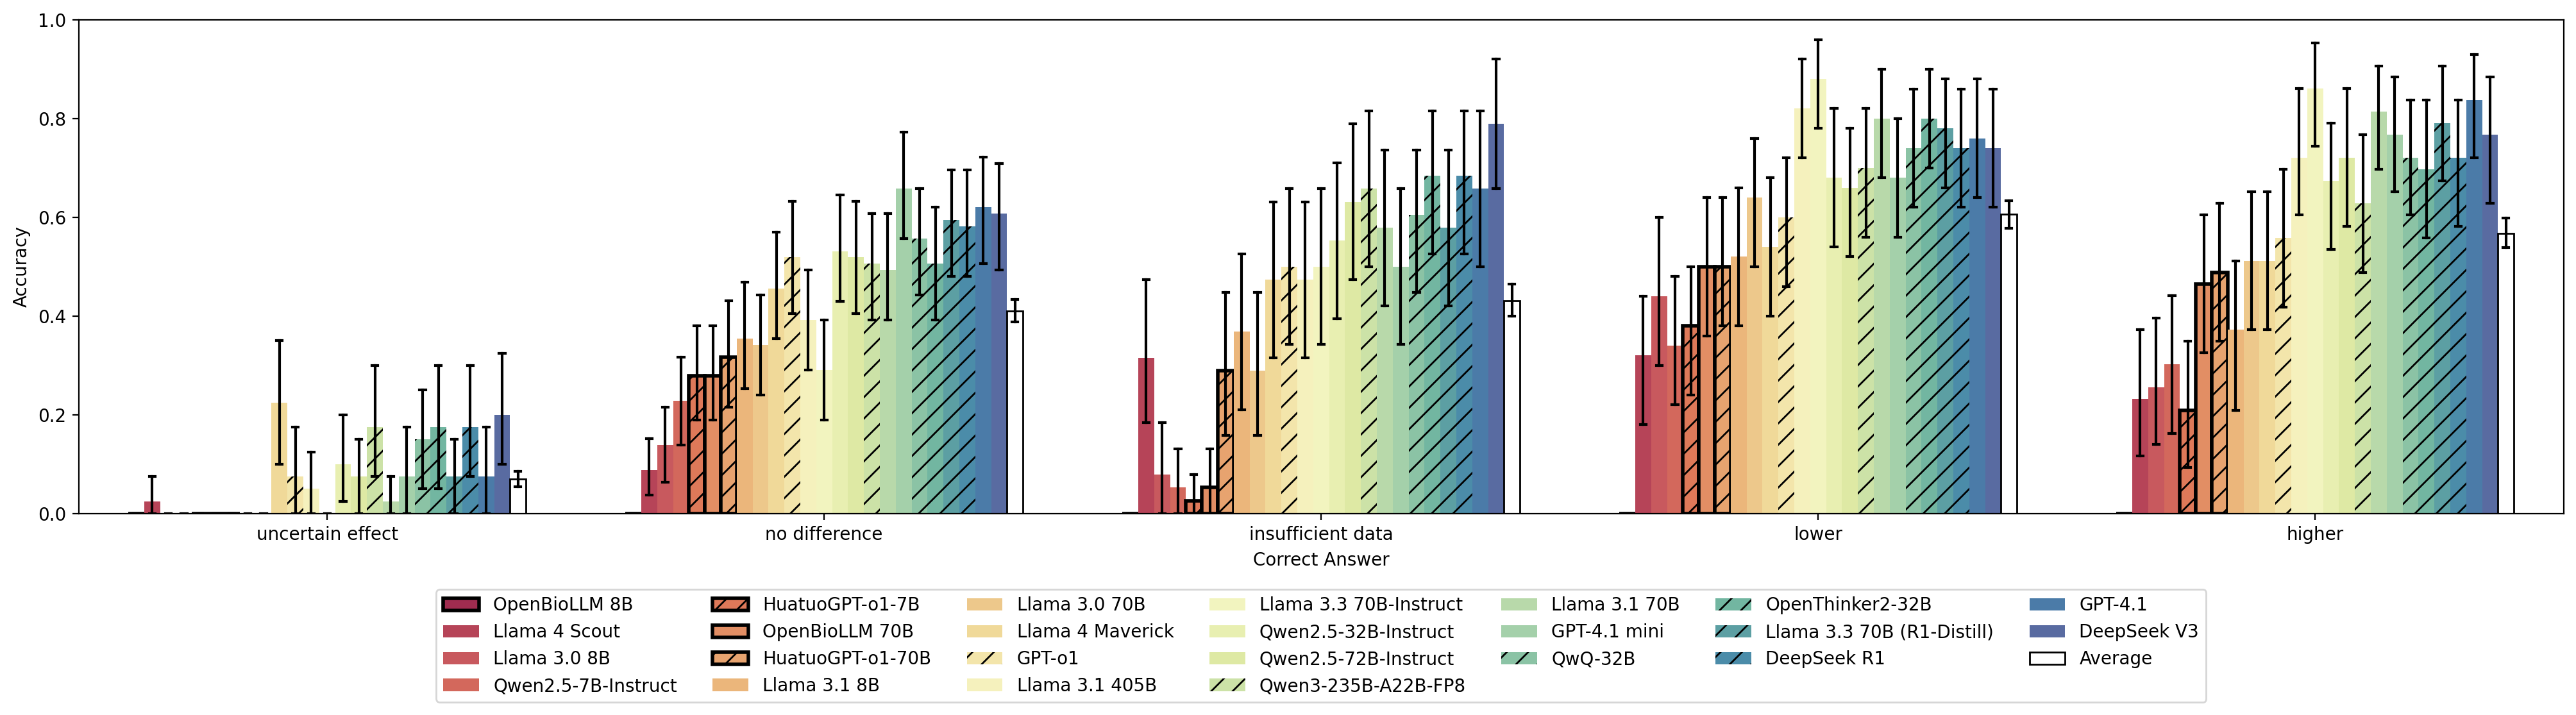

In [379]:
### APPENDIX VERSION OF PER-CLASS PERFORMANCE
fig, ax = plt.subplots(figsize=(25,5), dpi=200)
# AVG_COLOR = 'white'
# long_df_2 = long_df.copy(deep=True)
# long_df_2["Model"] = "Average"
# long_df_2["is_medical"] = 0
# long_df_2["Reason Type"] = "Non-Reasoning"

# catdf = pd.concat([long_df, long_df_2])
mypal = list(palette) + ['white']

sns.barplot(catdf, x='correct_answer', y='score', hue='Model', palette=mypal, ax=ax,
            order=['uncertain effect', 'no difference', 'insufficient data', 'lower', 'higher'],
            errorbar=('ci', 95), err_kws=dict(linewidth=1.5, color='#000000'), capsize=0.3)

for i, bars in enumerate(ax.containers):
    # Set a different hatch for each group of bars
    for bar in bars:
        if i >= len(model_order):
            bar.set_edgecolor('black')
            bar.set_linewidth(1)
            continue
        if model_order.iloc[i].is_medical:
            bar.set_edgecolor('black')
            bar.set_linewidth(2)
        if model_order.iloc[i]['Reason Type'] == 'Reasoning':
            bar.set_hatch('//')

handles, labels = ax.get_legend_handles_labels()
# Modify the patch properties
for i, handle in enumerate(handles):
    if i >= len(model_order):
        handle.set_edgecolor('black')
        handle.set_linewidth(1)
        continue
    if model_order.iloc[i].is_medical:
        handle.set_edgecolor('black')
        handle.set_linewidth(2)
    if model_order.iloc[i]['Reason Type'] == 'Reasoning':
        handle.set_hatch('//')
ax.set_ylim(0, 1)
ax.set_xlabel('Correct Answer')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=7)
fig.show()
fig.savefig('appendiximgs/perClassRecall.pdf', bbox_inches='tight')

In [ ]:
pal = palette
fig, ax = plt.subplots(dpi=200, figsize=(4.1,5))
pairs = [
    "OpenBioLLM 8B", "Llama 3.0 8B",
    "HuatuoGPT-o1-7B", "Qwen2.5-7B-Instruct",
    "OpenBioLLM 70B", "Llama 3.0 70B",
    "HuatuoGPT-o1-70B", "Llama 3.1 70B"
]
medpairdf = long_df.set_index('Model').loc[pairs, :].reset_index(names='Model')
medmodelorder = model_order.set_index('Model').loc[pairs,:].reset_index()
colors = []
for p in pairs:
    ix = model_order.set_index('Model').index.get_loc(p)
    colors.append(pal[ix])
sns.barplot(medpairdf, y='Model', x='score', hue='Model', palette=colors, legend=False, orient='h', ax=ax,
            errorbar=('ci', 95), err_kws=dict(linewidth=1.5, color='#000000'), capsize=0.3)
for i, bar in enumerate(ax.patches[-len(medpairdf):]):
    if medmodelorder.iloc[i].is_medical:
        bar.set_edgecolor('black')
        bar.set_linewidth(2)
    if medmodelorder.iloc[i]['Reason Type'] == 'Reasoning':
        bar.set_hatch('//')
for i in range(len(pairs)//2):
    if i % 2 == 1:
        ax.axhspan(2*i-0.5, 2*i+1.5, facecolor='lightgrey', alpha=0.5, edgecolor=None, zorder=0)
legend_elements = [
    Patch(facecolor='grey', hatch='//', label=f'Reasoning'),
    Patch(facecolor='grey', hatch='', label=f'Non-Reasoning'),
    Patch(facecolor='grey', edgecolor='black', linewidth=2, hatch='', label=f'Medically Finetuned')
]
ax.legend(handles=legend_elements)
# ax.set_xlim(0,1)
ax.set_xlabel('Accuracy')
ax.set_ylabel('')
fig.show()
fig.savefig('figs/medFtuneVSbase.pdf')

In [ ]:
template = r"""
\begin{figure}
    \centering
    \includegraphics[width=0.8\linewidth]{img/confmats/MODEL.pdf}
    \caption{Confusion matrix for DISPLAY.}
\end{figure}
"""

outs = []
for (modelname, display_name, model_series, is_reasoning, model_size, is_medical) in sorted(outfiles, key=lambda t: t[1]):
    outs.append(template.replace('MODEL',modelname).replace('DISPLAY', display_name))
print('\n'.join(outs))

In [ ]:
def confmatplot(ax=None, avg=True, acc_thresh=0, **kwargs):
    basepath = analysis_sets[0][1]
    all_mats = []
    for (modelname, display_name, model_series, is_reasoning, model_size, is_medical) in outfiles:
        filepath = basepath.format(MODEL=modelname)
        eval_df = grade(filepath)
        acc = eval_df.score.mean()
        if acc < acc_thresh:
            continue
        mat = conf_mat(eval_df)
        all_mats.append(mat)
        if not avg:
            fig, ax = plt.subplots(dpi=200)
            sns.heatmap(mat, ax=ax, **kwargs)
            ax.set_xlabel('Correct')
            ax.set_ylabel('Predicted')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=8)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=30, fontsize=8)
            # ax.set_title(display_name)
            fig.savefig(f'appendiximgs/confmats/{modelname}.pdf', bbox_inches='tight')
    if avg:
        avg_mat = functools.reduce(lambda x, y: x.add(y, fill_value=0), all_mats)  / len(all_mats)
        if ax is None:
            fig, ax = plt.subplots(dpi=200)
        sns.heatmap(avg_mat, ax=ax, **kwargs)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Correct')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=8)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=30, fontsize=8)
        return ax

confmatplot(avg=False, cbar=True, annot=True)

# fig, axs = plt.subplots(figsize=(15,5), ncols=2, width_ratios=[1, 1.26])
# confmatplot(ax=axs[0], avg=True, acc_thresh=0, cbar=False, annot=True)
# confmatplot(ax=axs[1], avg=True, acc_thresh=0.4, annot=True)
# fig.subplots_adjust(wspace=0.3)
# axs[0].set_title("(a)", loc='left', fontsize=TITLE_SIZE)
# axs[1].set_title("(b)", loc='left', fontsize=TITLE_SIZE)
# for ax in axs:
#     ax.set_aspect('equal','box')
# axs[1].set_ylabel(None)
# fig.show()
# fig.savefig(f'appendiximgs/avgConfMats.pdf', bbox_inches='tight')

/var/folders/cp/ps4v9yh52dj0wy2dnwf912cr0000gn/T/ipykernel_26198/4102526116.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


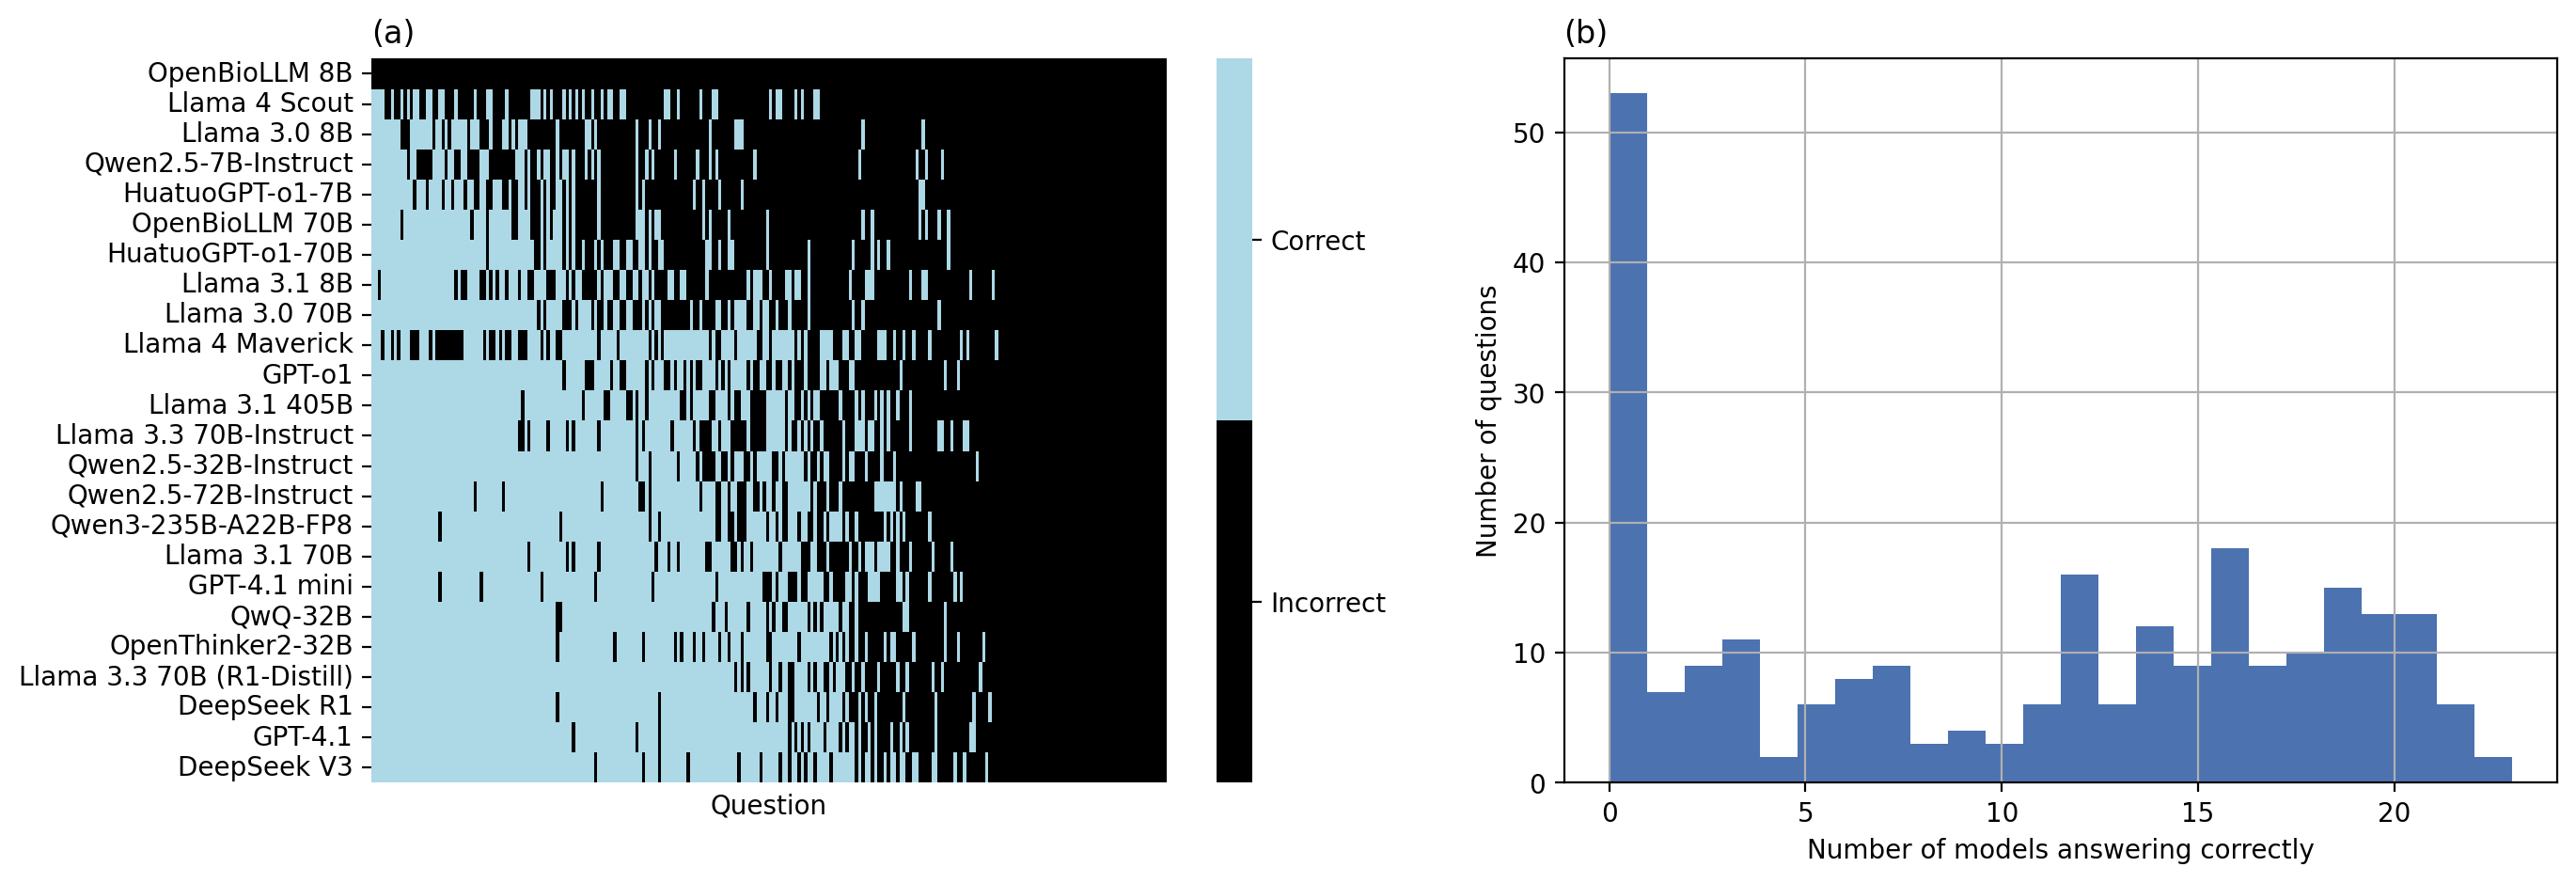

In [608]:
from collections import Counter
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter
joint_key = "score"
joint_basecols = ["question_id"]
joint_df = pd.DataFrame()
cmap = colors.ListedColormap(['black', 'lightblue'])
for (modelname, display_name, model_series, is_reasoning, model_size, is_medical) in outfiles:
    filepath = basepath.format(MODEL=modelname)
    eval_df = grade(filepath)
    if joint_df.empty:
        joint_df = eval_df[joint_basecols]
    _subset = eval_df[["question_id", joint_key]].rename(columns={joint_key: display_name})
    joint_df = joint_df.merge(_subset, how='outer', on=["question_id"])
joint_df['model_sum'] = joint_df.iloc[:, 1:].sum(axis=1)
joint_df = joint_df.sort_values('model_sum', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(dpi=200, figsize=(15,5), ncols=2)
tickformat = lambda x, _: 'Incorrect' if x < 0.5 else 'Correct'
sns.heatmap(joint_df.loc[:, model_order.Model.values].T, cmap=cmap, ax=ax[0], cbar_kws={'ticks': [0.25, .75], 'format': FuncFormatter(tickformat)})
ax[0].set_xticks([])
ax[0].set_xlabel('Question')
ax[0].set_title('(a)', loc='left')
ax[1].set_title('(b)', loc='left')

joint_df.model_sum.hist(bins=len(model_order), ax=ax[1])#, weights=np.ones(len(joint_df)) / len(joint_df), ax=ax)
ax[1].set_ylabel('Number of questions')
# ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
# ax.set_title('Questions by percentage of models answering them correctly')
ax[1].set_xlabel('Number of models answering correctly')
ax[1].set_ylabel('Number of questions')

fig.show()
fig.savefig(f'appendiximgs/qAccByModel.pdf', bbox_inches='tight')
# all_wrong_mask = ~joint_df.set_index('question_id').any(axis=1).values
# Counter(eval_df[all_wrong_mask].correct_answer.values)

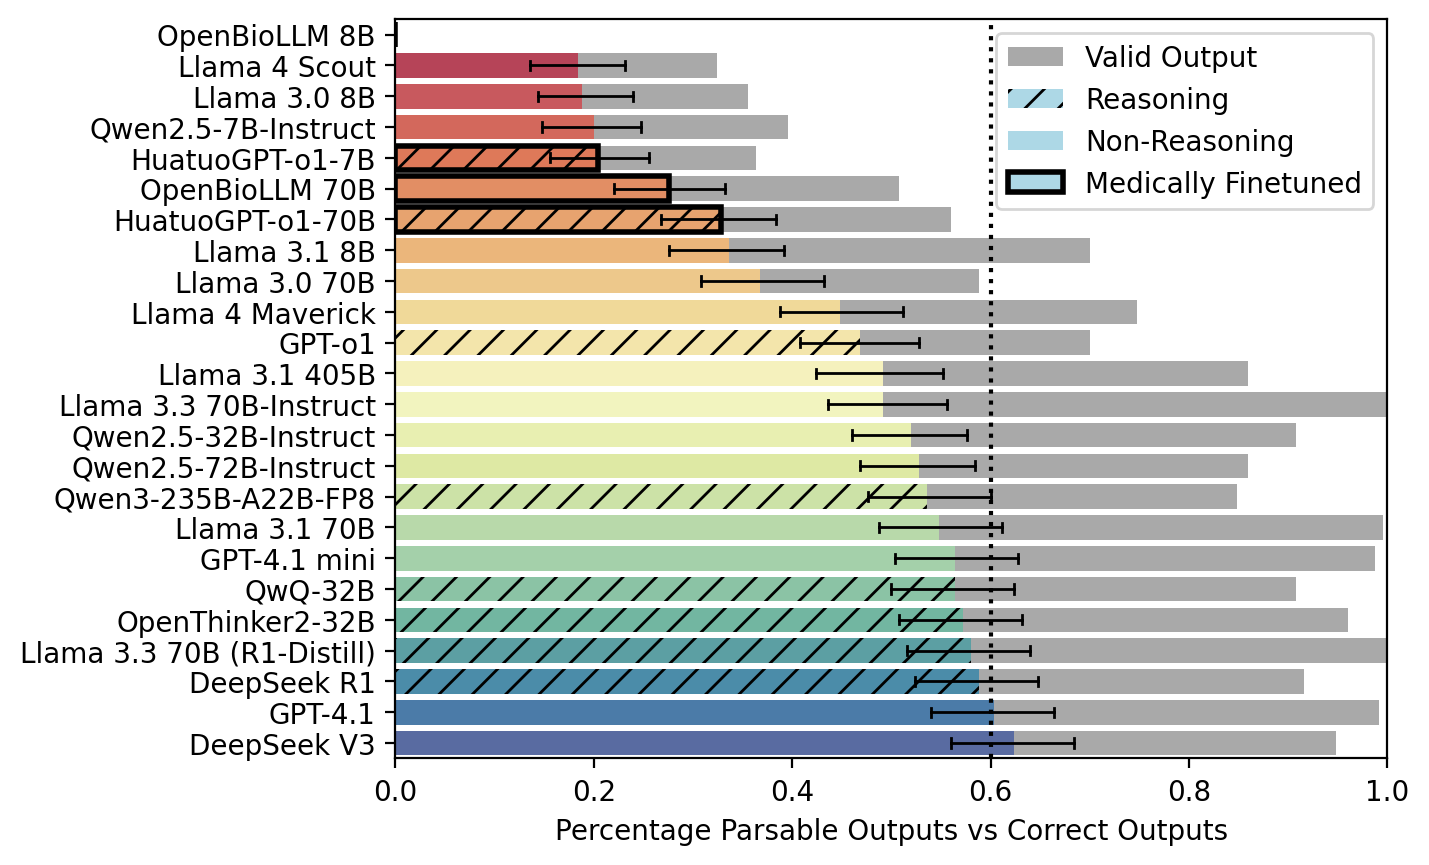

In [15]:

fig, ax = plt.subplots(dpi=200)
percent_valid_plot(ax, long_df, palette)
ax.axvline(0.6, color='k', linestyle=':')
# ax.axvline(0.9, color='k', linestyle=':')
# fig.savefig(f'[NeuRIPS-2025] MedEvidence Benchmark/img/percentParsableOutput.pdf', bbox_inches='tight')

In [117]:
_df = long_df
_df['valid'] = (_df.pred_answer != 'invalid')
_df = _df.groupby('Model').agg({'score':'sum', 'valid': 'sum'})
_df = _df[_df.valid > 0]
(_df['score']/_df['valid']).mean(), (_df['score']/_df['valid']).std()

(np.float64(0.5814658236809215), np.float64(0.05040906450489213))

### latex-coding lol

In [671]:
TEMPLATE = r"""
\begin{QualExample}{Question ID _Q_ID - _N_MODELS/24 models correct}
    \textbf{Review PMID:} _REVIEW_PMID\\
    \textbf{Question:} _QUESTION\\
    \textbf{Correct Answer:} \texttt{_ANSWER}\\
    \textbf{PMIDs of Relevant Sources:} _SOURCE_LIST\\
    \noindent\rule{\linewidth}{0.4pt}\\
    \textbf{DeepSeek V3 Response:}
    \begin{lstlisting}
_MODEL_RESPONSE
    \end{lstlisting}
    \noindent\rule{\linewidth}{0.4pt}
    \textbf{Remarks:} _REMARKS
\end{QualExample}
"""
fills = edict(
    _Q_ID=None,
    _N_MODELS=None,
    _REVIEW_PMID=None,
    _QUESTION=None,
    _ANSWER=None,
    _SOURCE_LIST=None,
    _MODEL_RESPONSE=None,
    _REMARKS=None
)

In [654]:
with open('run-med-evidence/___res/deepseekV3_closed_barebones_fulltext.jsonl', 'r') as fh:
    raw = [edict(json.loads(l)) for l in fh]
response_map = {o.question_id: o.answer for o in raw}

In [676]:
section_questions = [(r"\subsection{Questions where all models are wrong}", (
        (1, "In the SR, authors perform meta-analysis and find no overall significant difference between retroperitoneal drainage and no drainage. DeepSeek V3 does not appear to know how to perform any kind of reconcilliation. We note that Article 12214830 does not specify the raw number of events under both treatments, but does state that no lymphocysts (i.e. 0) were detected in the drainage group."),
        (198, """The authors of the SR state that the results are inconclusive for the following reasons: (a) "risk of bias: considerable missing data for PCR-tests for staff (data were available for 76\\% control schools and 83\\% intervention schools)" and (b) "imprecision: the confidence intervals are wide and the 95\\% CI crosses the line of no effect." In this case, the full-text article is open-source, so LLMs theoretically had access to essentially all the same information as the SR authors, but evidently, none of these concerns are addressed in DeepSeek V3's response. Furthermore, the DeepSeek V3 response focuses only on symptomatic PCR-confirmed infections, demonstrating limitations in its knowledge of medical contexts, as the question calls for an assessment of any PCR positive infections, which includes asymptomatic cases."""),
        (32, "This is a relatively challenging question—in the original SR, the authors compare the improvements in FSS in the placebo group directly to the improvements in the treatment group, rather than comparing the two treatment groups separately to their own baselines (which is what the authors of the cited source do). The source's abstract does state that smaller but non-significant improvements were present in the placebo group, albeit without providing numbers. Regardless, the LLM's response reads as a regurgitation of facts and lacks the critical thinking needed to critically assess cited studies."),
    )), (r"\subsection{Questions where most models are correct, but DeepSeek V3 is wrong}", (
        (6, "In this case, unlike most models (16/24 to be exact), DeepSeek V3 seems to 'overthink' the question and hone in on a single case where a sub-analysis of in Article 23514286 finds a significant benefit. Notably, SRs typically use intention-to-treat analysis (https://training.cochrane.org/handbook/current/chapter-06), which DeepSeek V3 fails to consider. Furthermore, as in prevous cases, no clear efforts to perform meta-analysis or aggregate studies are shown in DeepSeek V3's response."),
        (106, "This is case where DeepSeek V3 seems to fail due to a misinterpretation of the question, although we believe the semantics of this question are unambiguous. DeepSeek V3 does not seem to pick up on the mention of placebo in the question at all."),
        (163, "An example of an instruction-following failure for DeepSeekV3 (even though the overall analysis leads to a correct solution)."),
    )), (r"\subsection{Questions where most models are correct, including DeepSeek V3}", (
        (160, "While this question involves multiple sources, both sources individually agree with the overall correct conclusion, making it fairly straightforward to answer; consequently, almost all models get this question correct."),
        (214, "A straightforward question that all models (except OpenBioLLM 8B) get correct: one source accurately directly reports on relevant findings without conclusions being revised by the SR authors' critical analysis."),
    )), (r"\subsection{Questions where DeepSeek V3 is correct, despite most models being wrong}", (
        (235, """DeepSeek V3 correctly recognizes that none of the relevant studies provide direct, quantitative analysis on QoL outcomes; given the very low model correctness rate (3/24), other models likely attempted to apply colloquial definitions of "quality of life" rather than the narrowly-defined medical definition requiring explicit quantitative measurement."""),
        (89, """While DeepSeek V3 does get this question right, and shows flashes of attempting deeper reasoning (e.g. the remark that the effect "may depend on the type of breast surgery"), but this analysis is not directly supported by similar statements from the original SR authors. Additionally, there is still no formal aggregation or meta-analysis attempted, and the level of detail in the reasoning provided by DeepSeek V3 makes it hard to tell if the model's predicted answer was made via some form of intuition or if the model just got a bit lucky."""),
        (173, "Even without explicit prompting, DeepSeek V3 recognizes the weakness of the limited sample size/total number of events—the fact that only DeepSeek V3 gets this question correct shows both the current limitations of models' ability to assess uncertainty, as well as the promise that they may be able to do so consistently in the future.")
    ))
]

_df = setupdf.set_index('question_id')
outs = []

def fill_template(fill_data, s=TEMPLATE):
    for k,v in fill_data.items():
        s = s.replace(k, v)
    return s

for header, questions in section_questions:
    outs.append(header)
    for q_id, remarks in questions:
        row = _df.loc[q_id]
        fills._Q_ID = str(q_id)
        fills._N_MODELS = str(joint_df.set_index('question_id').loc[q_id].model_sum.item())
        fills._REVIEW_PMID = str(row.review_pmid)
        fills._QUESTION = row.question
        fills._ANSWER = row.answer
        fills._SOURCE_LIST = ', '.join(row.relevant_sources)
        fills._MODEL_RESPONSE = response_map[q_id]
        fills._REMARKS = remarks
        outs.append(fill_template(fills))
print('\n'.join(outs))


\subsection{Questions where all models are wrong}

\begin{QualExample}{Question ID 1 - 0/24 models correct}
    \textbf{Review PMID:} 28660687\\
    \textbf{Question:} Is the short-term rate of overall lymphocyst formation higher, lower, or the same when comparing retroperitoneal drainage to no drainage?\\
    \textbf{Correct Answer:} \texttt{no difference}\\
    \textbf{PMIDs of Relevant Sources:} 9190979, 12214830\\
    \noindent\rule{\linewidth}{0.4pt}\\
    \textbf{DeepSeek V3 Response:}
    \begin{lstlisting}
- **Rationale**: 
  - Article ID 9190979 reports that the complication rate, including lymphocyst formation, was significantly higher in the drained group (Group A) compared to the not-drained group (Group B) (P = 0.01). However, sonographic monitoring showed free abdominal fluid (a proxy for lymphocyst formation) in 18% of drained patients vs. 36% of not-drained patients (P = 0.03), suggesting a lower rate in the drained group. This creates a contradiction in the findings.
 